In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
from jax import random
import seaborn as snb
import scipy.stats as stats
import os
import sys
sys.path.append(os.path.abspath('..'))
# distributions
from scipy.stats import norm
from scipy.stats import multivariate_normal as mvn
from scipy.stats import poisson

# for plotting and visualization
from exercise8 import plot_predictions
from exercise8 import eval_density_grid

# style stuff
snb.set_style('darkgrid')
snb.set(font_scale=1.25)

import jax

# Configure JAX to use 64-bit floating-point numbers (float64) instead of the default 32-bit (float32).
# This increases numerical precision, which can be important for numerical stability in algorithms like MCMC or optimization.
jax.config.update("jax_enable_x64", True)

# 02477 Bayesian Machine Learning - Exercise 8

The purpose of this exercise is to become familiar with sampling-based methods. We will briefly touch **ancestral sampling** and **importance sampling**, but spend most of the time diving into **Markov Chain Monte Carlo methods** via the **Metropolis-Hastings algorithm**. After studying the properties of the algorithms, we will apply to a Poisson regression model for fully Bayesian inference.

**Content**

- Part 1: Ancestral sampling
- Part 2: Implementing the Metropolis-Hastings algorithm
- Part 3: The Metropolis-Hastings algorithm for 1D and 2D problems 
- Part 4: Metroplis-Hastings for Bayesian Poisson regression
- Part 5: Importance sampling



**Note**: The exercise contains several **discussion questions**, which are questions, where are supposed to actively experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs. Instead of proving the full description for every discussion question, we simply tag it with: [**Discussion question**] after the question.

For later convenience, we will implement the density of the normal and the so-called half-normal distributions:

In [3]:
# Normal distribution (univariate) (univariate)
# Equation: 
#   log N(x | m, v) = -0.5 * ((x - m)^2 / v) - 0.5 * log(2πv)5 * log(2πv)
#   N(x | m, v) = exp(log N(x | m, v))#   N(x | m, v) = exp(log N(x | m, v))
# Shapes:
#   x: scalar or array (...,)
#   m: scalar (mean) (mean)
#   v: scalar (variance)#   v: scalar (variance)
log_npdf = lambda x, m, v: -0.5 * (x - m) ** 2 / v - 0.5 * jnp.log(2 * jnp.pi * v)  # shape: same as x
npdf = lambda x, m, v: jnp.exp(log_npdf(x, m, v))  # shape: same as x

# Half-normal distribution (positive part of normal)
# Equation:


#   log Poisson(x | m) = x * log(m) - m - log(x!)
# Equation:
# Poisson distribution (log PMF)

half_npdf = lambda x, m, v: jnp.exp(log_half_npdf(x, m, v))  # shape: same as x
log_half_npdf = lambda x, m, v: jnp.log(2) - 0.5 * (x - m) ** 2 / v - 0.5 * jnp.log(2 * jnp.pi * v)  # shape: same as x
#   v: scalar (variance)
#   m: scalar (mean)
#   x: scalar or array (...,)
# Shapes:#   N_+(x | m, v) = exp(log N_+(x | m, v))#   log N_+(x | m, v) = log(2) - 0.5 * ((x - m)^2 / v) - 0.5 * log(2πv), for x >= 0


## Part 1:  Ancestral sampling

**Ancestral sampling** is a simple technique for sampling from joint probability distribution using conditional distributions. Consider the following model for $p(x_1, x_2, x_3, x_4)$:

$$\begin{align*}
x_1 &\sim \mathcal{N}(x_1|0, 3)\\
x_2 &\sim \mathcal{N}(x_2|1, 1)\\
x_3|x_2, x_1 &\sim \mathcal{N}(x_3|x_1+x_2, 2)\\
x_4|x_3 &\sim \mathcal{N}(x_4|x_3^2, 1)
\end{align*}$$

with the joint distribution given by
$$\begin{align*}
p(x_1, x_2, x_3, x_4) = p(x_1)p(x_2)p(x_3|x_1, x_2)p(x_4|x_3).
\end{align*}$$

**Task 1.1**: Use ancestral sampling to generate $S = 1000$ samples from the joint distribution $p(x_1, x_2, x_3, x_4)$.

*Hints*:
-  *Start by generating samples from the marginal distributions of $p(x_1)$ and $p(x_2)$, i.e. $x_1^{(i)} \sim p(x_1)$ and $x_2^{(i)} \sim p(x_2)$ for $i = 1, \dots, S$*
-  *Next, then for each pair of samples $x_1^{(i)}, x_2^{(i)}$ generate a sample from $x_3^{(i)} \sim p(x_3|x_1^{(i)}, x_2^{(i)})$ and so on.*
-  *You can use `jax.random.normal(key, shape=(S,))` to generate an array of `S` i.i.d. samples from $\mathcal{N}(0, 1)$*
-  *Recall: The `key`-argument in JaX determines the state for the random number generator, so if you call `jax.random.normal(key, shape=(S,))` several times in your code with the same key, then you'll get the exact same numbers every time. So make you to provide a different `key`.
- *You can split a single key into multiple keys as follows: `key1, key2, key3, key4 = random.split(key, num=4)`.*
-  More information about random number generation in JaX can be found here: https://docs.jax.dev/en/latest/random-numbers.html*



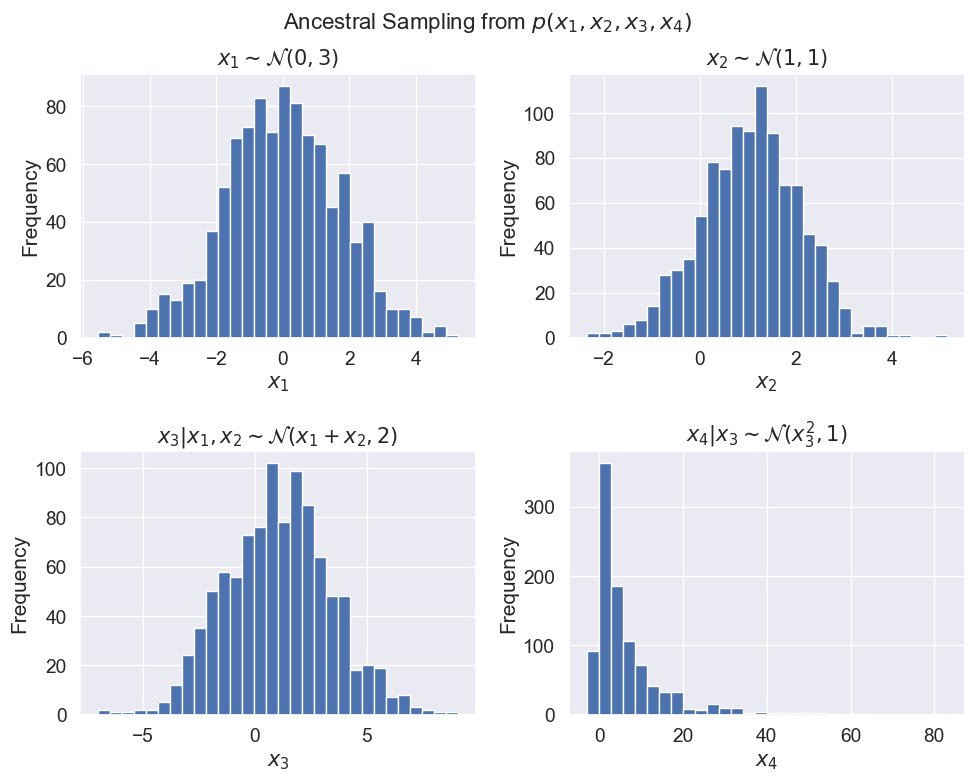

In [4]:
# Ancestral sampling for the joint distribution p(x1, x2, x3, x4)
# Model:
#   x1 ~ N(0, 3)
#   x2 ~ N(1, 1)
#   x3 | x1, x2 ~ N(x1 + x2, 2)
#   x4 | x3 ~ N(x3^2, 1)
#
# Joint: p(x1, x2, x3, x4) = p(x1) p(x2) p(x3|x1,x2) p(x4|x3)
#
# Number of samples
S = 1000

# 1. Set random seed and split keys for reproducibility
key = random.PRNGKey(1)
key1, key2, key3, key4 = random.split(key, num=4)

# 2. Sample x1 ~ N(0, 3)
#    Equation: x1 = sqrt(3) * N(0,1)
#    Shape: (S,)
x_1_samples = random.normal(key1, shape=(S,)) * jnp.sqrt(3.0)
# Output: x_1_samples.shape = (1000,)

# 3. Sample x2 ~ N(1, 1)
#    Equation: x2 = N(0,1) + 1
#    Shape: (S,)
x_2_samples = random.normal(key2, shape=(S,)) * jnp.sqrt(1.0) + 1.0
# Output: x_2_samples.shape = (1000,)

# 4. Sample x3 | x1, x2 ~ N(x1 + x2, 2)
#    Equation: x3 = N(0,1) * sqrt(2) + (x1 + x2)
#    Shape: (S,)
x_3_mean = x_1_samples + x_2_samples  # shape: (1000,)
x_3_samples = random.normal(key3, shape=(S,)) * jnp.sqrt(2.0) + x_3_mean
# Output: x_3_samples.shape = (1000,)

# 5. Sample x4 | x3 ~ N(x3^2, 1)
#    Equation: x4 = N(0,1) + x3^2
#    Shape: (S,)
x_4_mean = x_3_samples ** 2           # shape: (1000,)
x_4_samples = random.normal(key4, shape=(S,)) * jnp.sqrt(1.0) + x_4_mean
# Output: x_4_samples.shape = (1000,)

# Plot histograms for each variable
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

axes[0, 0].hist(x_1_samples, bins=30)
axes[0, 0].set_title('$x_1 \sim \mathcal{N}(0, 3)$')
axes[0, 0].set_xlabel('$x_1$')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(x_2_samples, bins=30)
axes[0, 1].set_title('$x_2 \sim \mathcal{N}(1, 1)$')
axes[0, 1].set_xlabel('$x_2$')
axes[0, 1].set_ylabel('Frequency')

axes[1, 0].hist(x_3_samples, bins=30)
axes[1, 0].set_title('$x_3|x_1,x_2 \sim \mathcal{N}(x_1+x_2, 2)$')
axes[1, 0].set_xlabel('$x_3$')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(x_4_samples, bins=30)
axes[1, 1].set_title('$x_4|x_3 \sim \mathcal{N}(x_3^2, 1)$')
axes[1, 1].set_xlabel('$x_4$')
axes[1, 1].set_ylabel('Frequency')

fig.suptitle('Ancestral Sampling from $p(x_1, x_2, x_3, x_4)$', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()



# TEACHER 
#key = random.PRNGKey(1)
#key1, key2, key3, key4 = random.split(key, num=4)
#
#S = 1000
#x1 = 0       + jnp.sqrt(3)*random.normal(key1, shape=(S, ))
#x2 = 1       + jnp.sqrt(1)*random.normal(key2, shape=(S, ))
#x3 = x1 + x2 + jnp.sqrt(2)*random.normal(key3, shape=(S, ))
#x4 = x3**2   + jnp.sqrt(1)*random.normal(key4, shape=(S, ))

**Task 1.2**: Use the samples from the previous task to compute the marginal mean, variance, and a 95\% interval of $p(x_4)$.



In [5]:
# Compute marginal mean, variance, and 95% interval for x_4_samples

# x_4_samples: shape (S,), S = 1000
# Each entry is a sample from the marginal distribution p(x_4)
# We want to compute:
#   - mean: E[x_4] ≈ (1/S) ∑_{i=1}^S x_4^{(i)}
#   - variance: Var[x_4] ≈ (1/S) ∑_{i=1}^S (x_4^{(i)} - mean)^2
#   - 95% interval: [q_{2.5}, q_{97.5}], where q_p is the p-th percentile

# Equation for mean:
#   mean = (1/S) * sum_{i=1}^S x_4_samples[i]
# Equation for variance:
#   var = (1/S) * sum_{i=1}^S (x_4_samples[i] - mean)^2
# Equation for 95% interval:
#   interval = [percentile(x_4_samples, 2.5), percentile(x_4_samples, 97.5)]

# Input:
#   x_4_samples: jaxlib.xla_extension.ArrayImpl, shape (1000,)
# Output:
#   Prints mean, variance, and 95% interval

print(f"The marginal mean of x_4 is {jnp.mean(x_4_samples):3.2f}")
print(f"The variance of x_4 is {jnp.var(x_4_samples):3.2f}")
print(f'95%-interval:  {np.array2string(jnp.percentile(x_4_samples, jnp.array([2.5, 97.5])), precision=2)}')


The marginal mean of x_4 is 6.70
The variance of x_4 is 91.92
95%-interval:  [-1.04 34.16]


Suppose, we had observed some data $\mathbf{y}$ with a dependence on $x_1$ such that

$$\begin{align*}
p(x_1, x_2, x_3, x_4|\mathbf{y}) = p(x_1|\mathbf{y})p(x_2)p(x_3|x_1, x_2)p(x_4|x_3).
\end{align*}$$


If we can generate sample from the posterior of $x_1$ given $\mathbf{y}$, then we can also use ancestral sampling to generate samples from $p(x_4|\mathbf{y})$ and subsequently compute summary statistics. We would follow the same strategy as in the previous two tasks, except we would start by sampling from $p(x_1|\mathbf{y})$ rather than $p(x_1)$. Later in the exercise, we will use **ancestral sampling** this way to make predictions in a Poisson regression model after having obtained posterior samples via MCMC. But before we'll get to that, we will first dive into MCMC and Metropolis-Hastings.

## Part 2:  Implementing the Metropolis-Hastings algorithm

Up until know we have used the **Laplace approximation** to **approximate** the posterior distribution of several models. Rather than approximating a target posterior using a specific family of distributions, e.g. Gaussians, sampling-based methods aim to generate samples from the distribution of interest without making any assumptions of the shape of the distribution.  If we can obtain a set of samples from the posterior, we can approximate all quantities of practical interest using the set of samples. For example, if $\mathbf{\theta}^{1}, \mathbf{\theta}^{2}, \dots, \mathbf{\theta}^{S} \sim p(\mathbf{\theta}|\mathbf{y})$ for $\theta \in \mathbb{R}^D$, then we can approximate the posterior expectation of any function $f(\theta)$ using a **Monte Carlo estimator** as follows

$$\begin{align*}
    \mathbb{E}_{\mathbf{\theta}|\mathbf{y}}\left[f(\mathbf{\theta})\right] \approx \frac{1}{S}\sum_{i=1}^S f(\mathbf{\theta}^i).
\end{align*}$$

In practice, it turns out to be very difficult to obtain **i.i.d** samples from general posterior distributions.  However, **Markov Chain Monte Carlo methods (MCMC)** provides a method for generating samples from almost any reasonable distribution, but the price we pay is that the samples are often highly correlated, thus reducing the effective sample size.

The core idea of MCMC methods is to construct a Markov chain such that its **stationary distribution** will be equal to the distribution we want to sample from. Informally, we are creating a type of random walk that explores the parameter space of the target distribution in way where regions with high density are visited more frequently than areas with low density.



**The Metropos-Hastings algorithm**

Today, we will work with the algorithm called the **Metropolis-Hastings**  algorithm, which is a generalization of the **Metropolis** algorithm discussed in the lecture. 

The purpose of the Metropos-Hastings algorithm is to generate samples from a distribution of interest. We will refer to this distribution as the **target** distribution and denote it by $p_t$. This could be any distribution, e.g. a prior distribution such that $p_t(\theta) = p(\theta)$ or a posterior distribution such that $p_t(\theta) = p(\mathbf{\theta}|\mathbf{y})$. A key property of the algorithm is that we only need t obe able to evaluate the target density up to constant, i.e. if $p_t(\mathbf{\theta}) = \frac{1}{Z}\tilde{p}_t(\mathbf{\theta})$ for some unknown $Z > 0$, then it is sufficient to be able to evaluate $\tilde{p}_t(\mathbf{\theta})$. The normalization constant $Z$ often involves a complex, high-dimensional integral that's difficult or impossible to compute directly. This constant will actually cancel out (as shown in the lecture).

Every iteration of the MH algorithm proceeds as follows. Assume that the sample at iteration $k-1$ is $\theta^{k-1}$ and we want to compute the sample for iteration $k$. Then, the first step is to generate a new **candidate sample** $\theta^{\star}$ using a **proposal distribution** $q(\theta^{\star}|\theta^{k-1})$, where the proposal distribution is chosen in a way such that it is easy to sample from it. The **Metropolis**-algorithm requires the proposal distribution to be **symmetric**, whereas the **Metropolis-Hastings**-algorithm generalizes this to potential non-symmetric proposal distributions by accounting for the proposal distribution when computing the **acceptance probabilities**.

In this exercise, we will use isotropic Gaussian distributions as proposal distributions:

\begin{align*}
    q(\theta^{\star}|\theta^{k-1}) = \mathcal{N}(\theta^{\star}|\theta^{k-1}, \tau^2 \mathbf{I}) \quad\text{for}\quad \tau > 0,
\end{align*}

or equivalently,

\begin{align*}
    \theta^{\star} = \theta^{k-1} + e_n, \quad\quad e_n \sim \mathcal{N}(0, \tau^2 \mathbf{I}).
\end{align*}


That is, at iteration $k$, we generate the new candidate sample $\mathbf{\theta}^{\star}$ by taking sample for iteration $k-1$, i.e. $\mathbf{\theta}_{k-1}$, and adding a small amount of noise to it. The parameter $\tau^2$ controls the variance of the proposal distribution,  and hence, it controls how much noise we add to $\mathbf{\theta}^k$ when generating the candidate sample $\mathbf{\theta}^{\star}$. In other words, the parameter $\tau$ controls the **step-size** of the algorithm.
 
Once the candidate sample $\mathbf{\theta}^{\star}$ has been generated, the next step is to calculate the **acceptance probability** $A_k$ is given by

\begin{align*}
A_k = \min(1, r_k), \quad\quad\quad\text{where}\quad r_k = \frac{p_t(\mathbf{\theta}^{\star})  q(\mathbf{\theta}^{k-1}|\mathbf{\theta}^{\star}) }{p_t(\mathbf{\theta}^{k-1}) q(\mathbf{\theta}^{\star}|\mathbf{\theta}^{k-1})} \tag{1}.
\end{align*}

We now accept the new candidate sample $\mathbf{\theta}^{\star}$ with probability $A_k \in \left[0, 1\right]$. We can implement this mechanism by generating a sample $u_k \sim \mathcal{U}(0, 1)$ from a uniform distribution in the interval $(0, 1)$. If $u_k < A_k$, we accept the candidate $\mathbf{\theta}^{\star}$ and set $\mathbf{\theta}^{k} = \mathbf{\theta}^{\star}$. Otherwise, we reject new candidate and set $\mathbf{\theta}^{k} = \mathbf{\theta}^{k-1}$. That is

\begin{align*}
\mathbf{\theta}_k = \begin{cases}\mathbf{\theta}^{\star} & \text{if}\quad u_k < A_k\\ \tag{2}
\mathbf{\theta}^{k-1} & \text{otherwise}\end{cases}
\end{align*}

The Metropolis-Hastings algorithm proceeds like this until we have reached a predefined number of iterations. Recall, when working with probabilities on computers, it is numerically more stable to do as many calculations in the log-domain as possible and exponentiate as late as possible (if at all necessary). Therefore, we should calculate $\log(r_k)$ and calculate $A_k$ as

\begin{align*}
A_k = \min(1, \exp[\log(r_k)]) \tag{3}
\end{align*}


You task is now to implement the MH-hastings algorithm below. Since the MH-algorithm is inherently stochastic, it can be difficult to debug. Therefore, we will apply it to distribution, where we already know the mean and variance such that we can verify that the sampler works as intended. 

**Task 2.1**: Complete the implementation of the Metropolis-Hastings algorithm below. See eq. (1), (2) and (3) above. Don't hesitate to ask for help if you are stuck in this question.


In [6]:
def metropolis(log_target, num_params, tau, num_iter, theta_init=None, seed=0):    
    """ Runs a Metropolis-Hastings sampler 

        Arguments:
        log_target:         function for evaluating the log target distribution, i.e. log \tilde{p}(theta). The function expect a parameter of size num_params.
        num_params:         number of parameters of the joint distribution (integer)
        tau:                standard deviation of the Gaussian proposal distribution (positive real)
        num_iter:           number of iterations (integer)
        theta_init:         vector of initial parameters (np.array with shape (num_params) or None)        
        seed:               seed (integer)

        returns
        thetas              np.array with MCMC samples (np.array with shape (num_iter+1, num_params))
    """ 

    # set initial key
    key = random.PRNGKey(seed)

    # if there is no theta init, it starts with zero
    # theta init is \theta^{k-1}
    if theta_init is None:

        theta_init = jnp.zeros((num_params))
        print(f"Shape of theta init {theta_init.shape} is the same as a number of parameters {num_params}")
    # prepare lists 
    thetas = [theta_init] # list to store all samples, starting with the initial 
    accepts = [] # list of accepted proposals 
    log_p_theta = log_target(theta_init) # log probability of the initial position 

    for k in range(num_iter):
        
        

        # update keys: key_proposal for sampling proposal distribution and key_accept for deciding whether to accept or reject.
        key, key_proposal, key_accept = random.split(key, num=3)

        ##############################################
        # Your solution goes here
        ##############################################
        # Get the current state theta^{(k)} from the end of the list 
        theta_current = thetas[-1] # current position of the chain, \theta^{k-1}
        
        # 1. Propose a new state theta' ~ q(theta' | theta_current)
        # Draw from N(theta_current, tau^2 * I)
        noise = random.normal(key_proposal, shape=(num_params))
        theta_proposal = theta_current + tau * noise
        
        log_p_theta_proposal = log_target(theta_proposal)
        
        log_acceptance_ratio = log_p_theta_proposal - log_p_theta 
        
        u = random.uniform(key_accept)
        
        accept = jnp.log(u) < jnp.minimum(0.0, log_acceptance_ratio)
        
        if accept:
            thetas.append(theta_proposal)
            log_p_theta = log_p_theta_proposal
            accepts.append(1.)
        else: 
            thetas.append(theta_current)
            accepts.append(0)
        
        

        ##############################################
        # End of solution
        ##############################################

    print('Acceptance ratio: %3.2f' % jnp.mean(jnp.array(accepts)))

    # return as np.array
    thetas = jnp.stack(thetas)

    # check dimensions and return
    assert thetas.shape == (num_iter+1, num_params), f'The shape of thetas was expected to be ({num_iter+1}, {num_params}), but the actual shape was {thetas.shape}. Please check your code.'
    return thetas


# sanity check: estimate the mean and variance of a N(x|1,3) Gaussian distribution
p_target = lambda x: log_npdf(x, 1., 3.)
print(f"p_target shape {p_target(jnp.array([0])).shape} is the same as a number of parameters {1}")

# run sampler
thetas = metropolis(p_target, 1, 2., 20000, theta_init=jnp.array([0]))

# estimate the mean and variance of p_target and relative errors
mean_thetas, var_thetas = jnp.mean(thetas), jnp.var(thetas)
rel_err_mean, rel_err_var = (mean_thetas - 1.)/1., (var_thetas - 3.)/3.

print('\nSanity check: Running the sampling with N(x|1, 3) as target')
print(f'Estimated mean:\t\t{mean_thetas:3.2f} (rel. err: {rel_err_mean:3.2f})')
print(f'Estimated variance:\t{var_thetas:3.2f} (rel. err: {rel_err_var:3.2f})\n')

if np.abs(rel_err_mean) < 0.05 and np.abs(rel_err_var) < 0.05:
    print('The relative errors for the first two central moments are less than 5%. Everything looks ok.')
else:
    print('The relative errors for the first two central moments are larger than 5%. If this happens consistently, something is likely wrong. Check your implementation')

p_target shape (1,) is the same as a number of parameters 1
Acceptance ratio: 0.67

Sanity check: Running the sampling with N(x|1, 3) as target
Estimated mean:		1.05 (rel. err: 0.05)
Estimated variance:	3.09 (rel. err: 0.03)

The relative errors for the first two central moments are larger than 5%. If this happens consistently, something is likely wrong. Check your implementation


**Task 2.2**: Why is it not necessary to include the proposal probabilities $q(\theta^{k-1}|\theta^{\star})$ and $q(\theta^{\star}|\theta^{k-1})$ when computing the acceptance probability for Gaussian proposals?

**Solution**

We have that 

$$\begin{align*}
\frac{q(\mathbf{\theta}^{k-1}|\mathbf{\theta}^{\star})}{q(\mathbf{\theta}^{\star}|\mathbf{\theta}^{k-1})} = \frac{\mathcal{N}(\mathbf{\theta}^{k-1}|\mathbf{\theta}^{\star}, \tau \mathbf{I})}{\mathcal{N}(\mathbf{\theta}^{\star}|\mathbf{\theta}^{k-1}, \tau \mathbf{I})} = 1
\end{align*}$$

In fact, this is true for any **symmetric** proposal distribution. That is, the Metropolis-Hastings algorithm reduces to the Metropolis-algorithm for symmetric proposals.


**End of solution**






**Task 2.3**: What is the resulting acceptance probability $A_k$ when the candidate sample $\theta^{\star}$ has higher density value than the previous sample $\theta^{k-1}$?


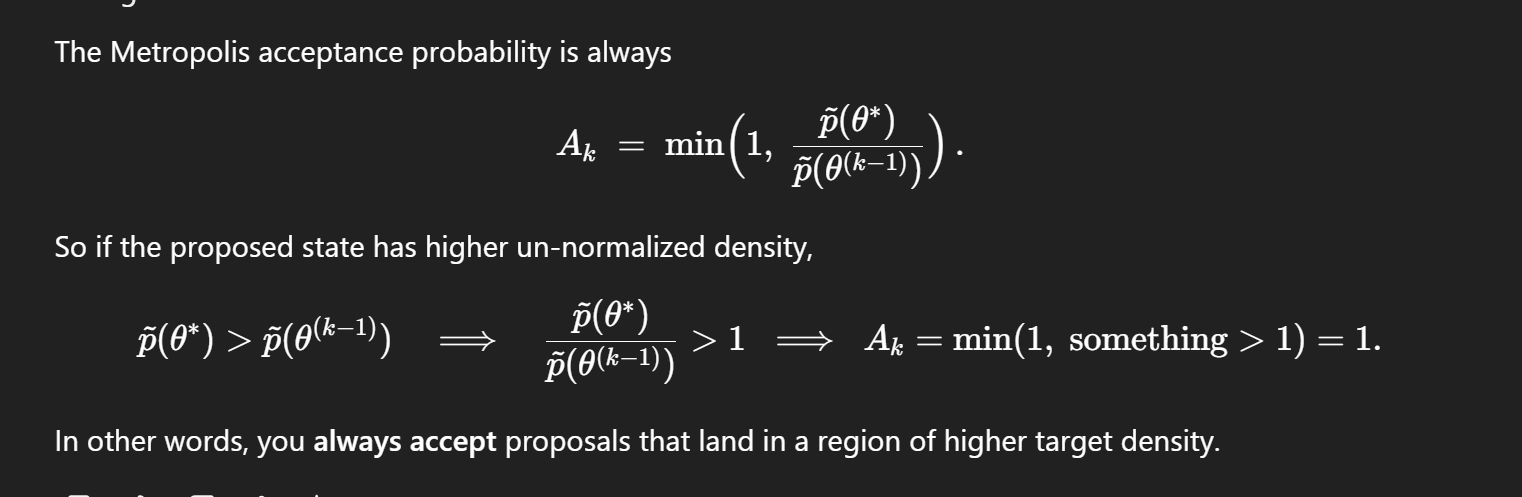


**Task 2.4**: Use eq. (1) one above to argue that we don't need to be able to evaluate the target distribution, but only the target density of up to a constant. That is, we only need to be evaluate $\tilde{p}_t$. Why is this important in Bayesian modelling?

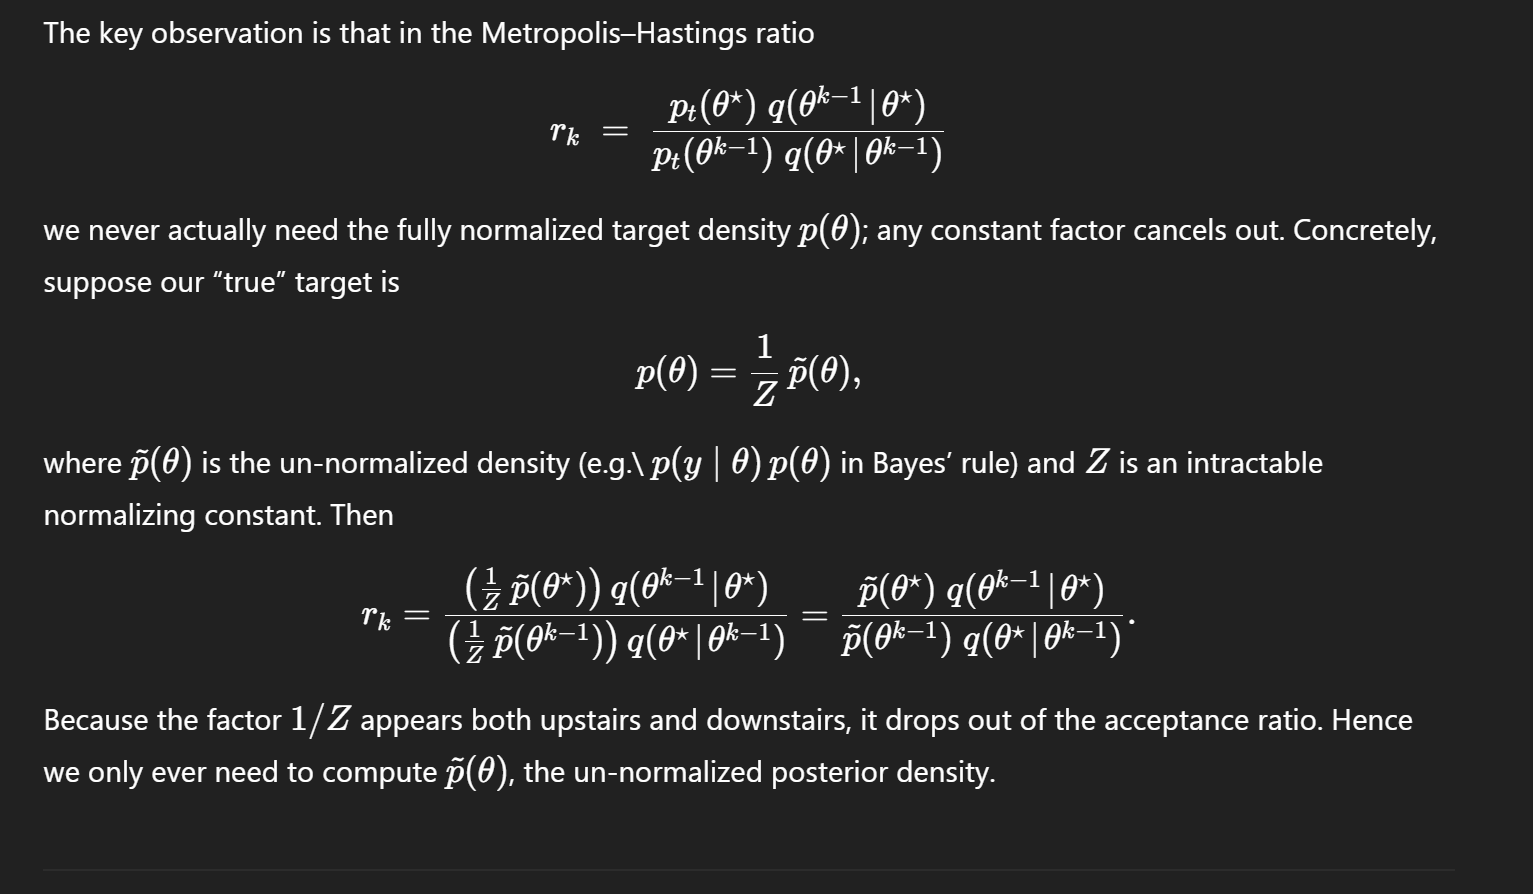
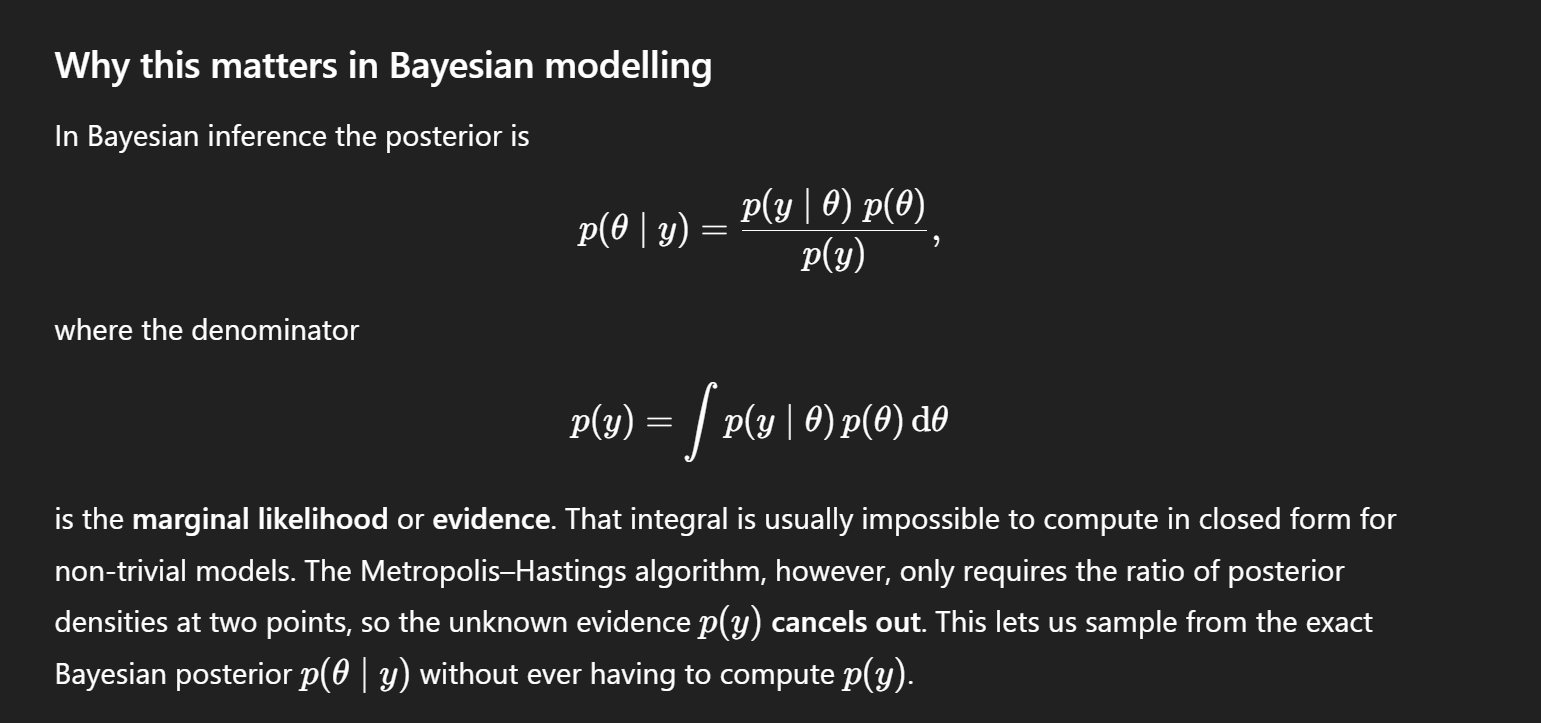

__________________________________________

Acceptance ratio: 0.53


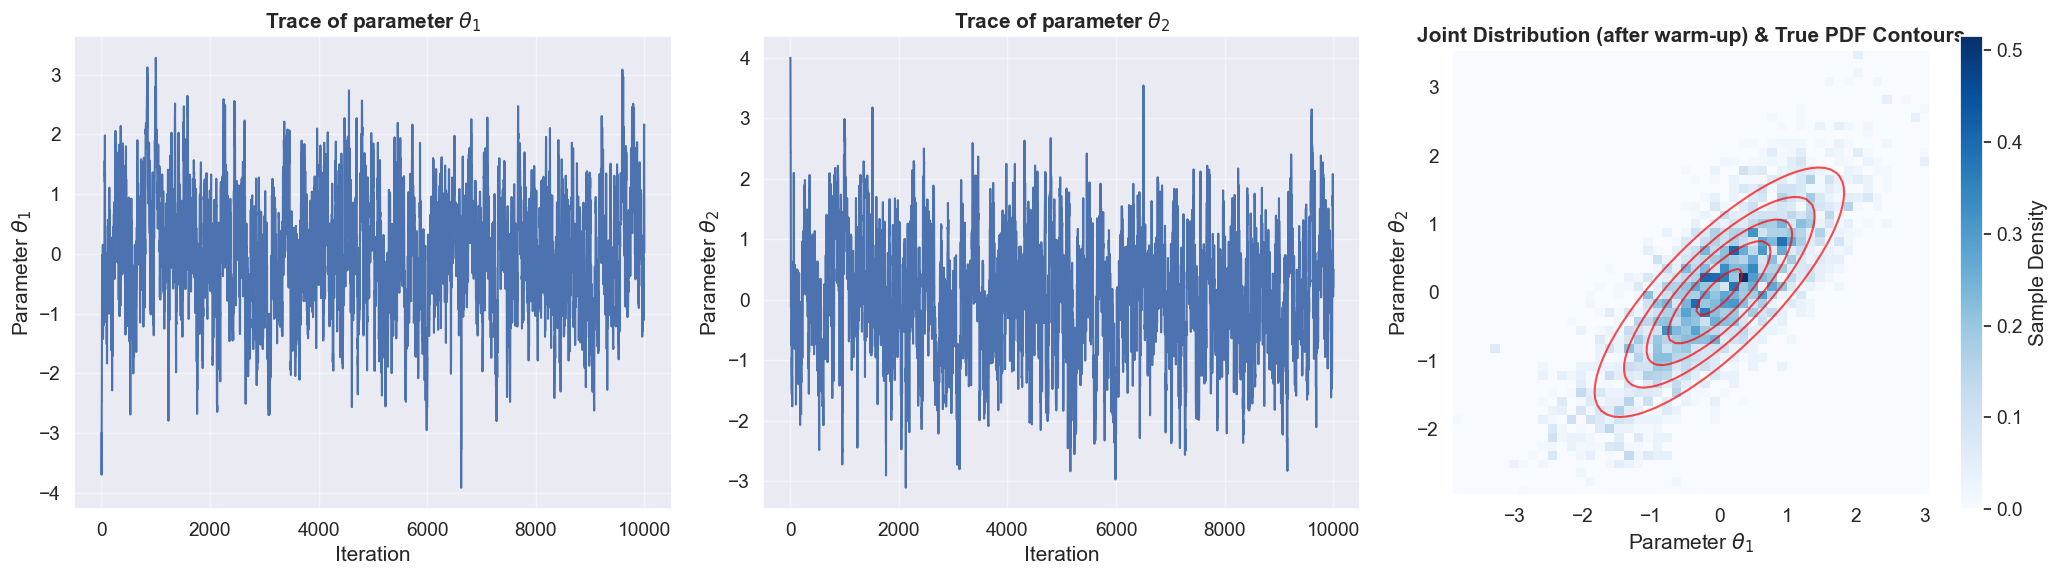

In [6]:
# Import necessary libraries
import jax.numpy as jnp
import jax.scipy.stats.multivariate_normal as multivariate_normal # For the 2D Normal PDF
import numpy as np
import matplotlib.pyplot as plt

# Assume 'log_npdf' (not used here) and the 'metropolis' function
# defined previously are available in the environment.

# --- Configuration for the 2D MCMC Sampling ---

# Specify number of parameters in the target distribution
num_params = 2                  # Define the dimensionality: 2 parameters (e.g., theta_1, theta_2).

# Specify the target distribution (2D Correlated Normal)
# Define the mean vector (mu) and covariance matrix (Sigma) for the target N(mu, Sigma).
mean_vec = jnp.array([0.0, 0.0]) # Target mean centered at (0, 0).
cov_matrix = jnp.array([[1.0, 0.8],  # Variance of theta_1 = 1.0
                        [0.8, 1.0]]) # Variance of theta_2 = 1.0
                                     # Covariance(theta_1, theta_2) = 0.8 (positive correlation)

# Define the log target function using JAX's multivariate normal log PDF.
# The function must accept a single argument: a JAX array 'theta' of shape (num_params,).
log_target = lambda theta: multivariate_normal.logpdf(theta, mean=mean_vec, cov=cov_matrix)

# Specify the parameters of the MH algorithm
num_iterations = 10000           # Increase iterations for potentially slower exploration in 2D.
warm_up = int(0.5 * num_iterations) # Discard the first 50% of samples as burn-in.
tau = 0.7                       # Proposal standard deviation (applied isotropically).
                                # This might need tuning for 2D problems to get a reasonable acceptance rate (e.g., 20-50%).
seed = 0                        # Random seed for reproducibility.
theta_init = jnp.array([-3.0, 4.0]) # Initial state (θ₀) for the 2D chain. Start away from the mean.

# --- Running the Sampler ---

# Run the Metropolis-Hastings sampler. The function remains the same,
# but now operates on 2D parameter vectors.
thetas = metropolis(
    log_target,                 # The 2D log-target function.
    num_params,                 # Number of parameters = 2.
    tau,                        # Proposal standard deviation.
    num_iterations,             # Total iterations.
    theta_init=theta_init,      # The 2D initial state.
    seed=seed                   # Random seed.
)
# 'thetas' is now a JAX array of shape (num_iterations + 1, 2).
# Column 0: samples for theta_1
# Column 1: samples for theta_2

# --- Plotting the 2D Results ---

# Create a figure and subplots. Let's use 3 plots:
# Trace plot for theta_1, Trace plot for theta_2, Joint distribution plot.
fig, axes = plt.subplots(1, 3, figsize=(21, 6)) # 1 row, 3 columns

# Plot 1: Trace Plot for theta_1
axes[0].plot(thetas[:, 0])       # Plot the first column of the samples.
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Parameter $\\theta_1$')
axes[0].set_title('Trace of parameter $\\theta_1$', fontweight='bold')
axes[0].grid(True, alpha=0.5) # Add grid for better readability

# Plot 2: Trace Plot for theta_2
axes[1].plot(thetas[:, 1])       # Plot the second column of the samples.
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Parameter $\\theta_2$')
axes[1].set_title('Trace of parameter $\\theta_2$', fontweight='bold')
axes[1].grid(True, alpha=0.5)

# Plot 3: Joint Distribution (after warm-up) vs True PDF Contours

# Select samples *after* the warm-up period for the joint plot.
thetas_after_warmup = thetas[warm_up:, :]

# Create a 2D histogram of the post-warm-up samples.
# 'bins=50' controls the resolution. 'cmap' sets the color map.
# 'density=True' normalizes the histogram.
counts, xedges, yedges, im = axes[2].hist2d(
    thetas_after_warmup[:, 0], # x-values (theta_1)
    thetas_after_warmup[:, 1], # y-values (theta_2)
    bins=50,
    density=True,
    cmap='Blues'
)
fig.colorbar(im, ax=axes[2], label='Sample Density') # Add a color bar to show density scale

# Create a grid to evaluate the true PDF for contour plotting.
x_grid = np.linspace(np.min(thetas_after_warmup[:, 0])-1, np.max(thetas_after_warmup[:, 0])+1, 100)
y_grid = np.linspace(np.min(thetas_after_warmup[:, 1])-1, np.max(thetas_after_warmup[:, 1])+1, 100)
X, Y = np.meshgrid(x_grid, y_grid)
pos = np.dstack((X, Y)) # Stack grid points into coordinates for logpdf evaluation

# Calculate the true PDF values on the grid.
Z = np.exp(multivariate_normal.logpdf(pos, mean=mean_vec, cov=cov_matrix))

# Overlay contour lines of the true PDF onto the histogram.
contour_set = axes[2].contour(X, Y, Z, levels=5, colors='red', alpha=0.7, linewidths=1.5)
# axes[2].clabel(contour_set, inline=True, fontsize=8) # Optional: label contour lines

axes[2].set_xlabel('Parameter $\\theta_1$')
axes[2].set_ylabel('Parameter $\\theta_2$')
axes[2].set_title('Joint Distribution (after warm-up) & True PDF Contours', fontweight='bold')
axes[2].set_aspect('equal', adjustable='box') # Ensure aspect ratio is equal for visual clarity

# Improve layout and display the plots
plt.tight_layout() # Adjust spacing between plots
plt.show()         # Show the figure

_____________________


## Part 3:  The Metropolis-Hastings algorithm for 1D and 2D problems 

The code below runs the Metropolis-Hastings algorithm for the target distribution specified through the **log_target** function. 

Acceptance ratio: 0.84


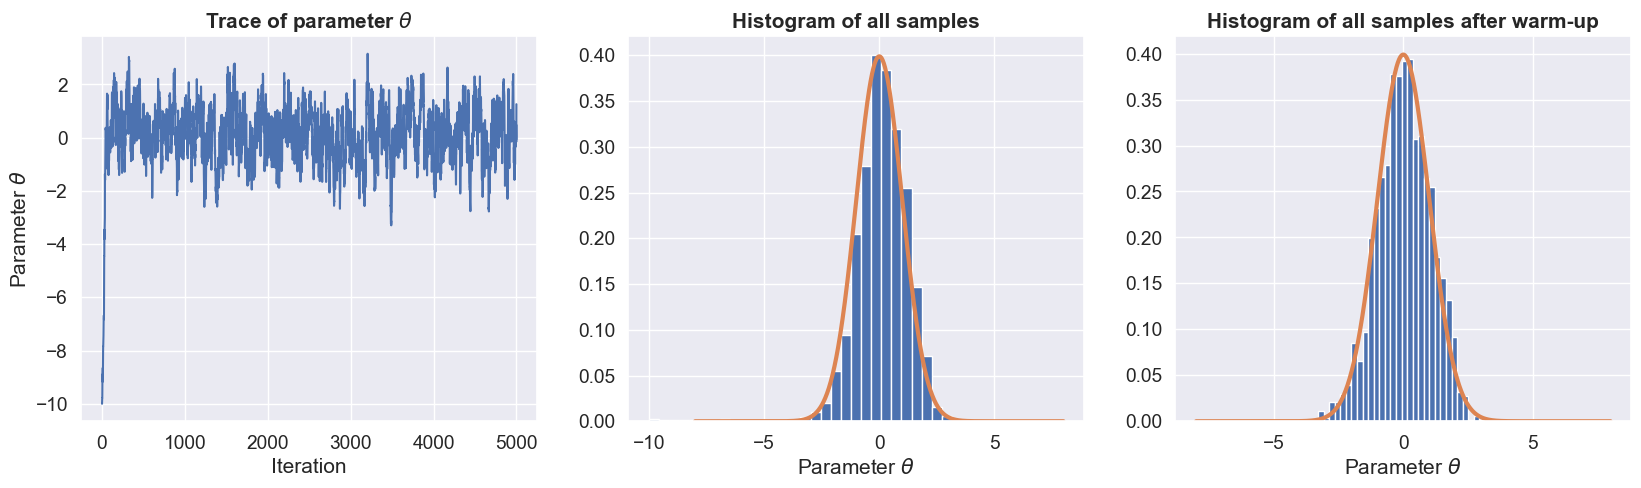

In [7]:
################################ SPECIFY NUMBER OF PARAMETERS AND TARGET DISTRIBUTION ################################
# specify number of parameters in the target distribution
num_params = 1                  # Define the dimensionality of the parameter space we are exploring.
                                # Here, it's 1 because we are sampling a single parameter theta from a 1D distribution.
#######################################################################################################################

################################ SPECIFY TARGET DISTRIBUTION #########################################################
# Define the target probability distribution we want to sample from.
# We provide it as a function that calculates the *logarithm* of the probability density (log-PDF).
# Using log probabilities helps prevent numerical underflow/overflow.
log_target = lambda x: log_npdf(x, 0, 1) # Target is a standard Normal distribution N(mean=0, variance=1).
                                         # log_npdf(value, mean, variance) returns the log-PDF.

################################ SPECIFY PARAMETERS ###################################################################
num_iterations = 5000           # Set the total number of steps the Metropolis-Hastings algorithm will run.
                                # This determines the total number of samples generated (including the initial state).

warm_up = int(0.5*num_iterations) # Define the number of initial iterations to discard (burn-in period).
                                  # MCMC samplers need time to converge from the initial state to the target distribution's typical set.
                                  # Samples during warm-up are usually not representative of the target distribution.
                                  # Here, we discard the first 50% of the chain.

tau = 0.5                       # Set the standard deviation (τ) for the Gaussian proposal distribution Q(theta' | theta).
                                # The proposal distribution used in this 'metropolis' implementation is N(theta_current, tau^2 * I).
                                # 'tau' controls the size of the proposed steps. Its value affects the acceptance rate
                                # and the efficiency of exploration. It often needs tuning.

########################################################################################################################

################################# RUN THE SAMPLER ######################################################################

initial_value = jnp.array([-10]) # Initial state (θ₀) for the Markov chain.                                               shape (1,).

# Run the Metropolis-Hastings sampler function with the specified configuration.
thetas = metropolis(
    log_target,                 # Pass the function that computes the log-probability of the target distribution.
    num_params,                 # Pass the number of parameters (dimensionality).
    tau,                        # Pass the proposal distribution standard deviation.
    num_iterations,             # Pass the total number of iterations to perform.
    theta_init=initial_value, # Provide the starting point (initial state, θ₀) for the Markov chain.
                                # Here, we start far from the mean of the target N(0,1). Must be a JAX array.
    seed=0                      # Provide a random seed for reproducibility of the random number generation within JAX.
)
# The 'thetas' variable now holds the output of the sampler:
# a JAX array of shape (num_iterations + 1, num_params), containing the sequence of sampled parameter values.
######################################################################################################################## 

################################### PLOTTING RESULTS ####################################################################

# Create an array of x-values to smoothly plot the true target distribution's PDF.
xs = np.linspace(-8, 8, 1000)    # Generate 1000 points evenly spaced between -8 and 8.

# Create a figure and a set of subplots (axes) to display the results.
# 1 row, 3 columns of plots. figsize controls the overall size.
fig, axes = plt.subplots(1, 3, figsize=(20, 5))


# Shows the value of the sampled parameter theta at each iteration.
axes[0].plot(thetas)             # Plot the sequence of samples stored in 'thetas'.
axes[0].set_xlabel('Iteration')  # Label the x-axis.
axes[0].set_ylabel('Parameter $\\theta$') # Label the y-axis (using LaTeX for the theta symbol).
axes[0].set_title('Trace of parameter $\\theta$', fontweight='bold') # Set the title for the first subplot.
# The trace plot helps visualize if the sampler is exploring the parameter space
# and if it appears to have converged (i.e., settled into a stable pattern around the target distribution).

# Plot 2: Histogram of ALL Samples vs True PDF
# Shows the distribution of all collected samples, including the warm-up phase.
axes[1].hist(thetas, 30, density=True); # Create a histogram of all values in 'thetas'.
                                        # '30' is the number of bins.
                                        # 'density=True' normalizes the histogram so its area integrates to 1,
                                        # allowing direct comparison with the probability density function.
# Overlay the true probability density function (PDF) of the target distribution N(0, 1).
axes[1].plot(xs, np.exp(log_target(xs)), linewidth=3) # Calculate the PDF by exponentiating the log-PDF.
                                                    # Plot it as a line over the histogram.
axes[1].set_xlabel('Parameter $\\theta$') # Label the x-axis.
axes[1].set_title('Histogram of all samples', fontweight='bold') # Set the title for the second subplot.
# This plot shows how well the entire chain (including initial exploration) covers the target distribution.
# Discrepancies might be visible due to the influence of the initial state and warm-up phase.

# Plot 3: Histogram of Samples AFTER Warm-up vs True PDF
# Shows the distribution of samples *after* discarding the warm-up phase.
axes[2].hist(thetas[warm_up:], 30, density=True); # Create a histogram using only the samples *after* the warm_up index.
                                                 # thetas[warm_up:] slices the array to exclude the first 'warm_up' samples.
                                                 # Uses the same number of bins and normalization as Plot 2.
# Overlay the true probability density function (PDF) again for comparison.
axes[2].plot(xs, np.exp(log_target(xs)), linewidth=3)
axes[2].set_xlabel('Parameter $\\theta$'); # Label the x-axis.
axes[2].set_title('Histogram of all samples after warm-up', fontweight='bold'); # Set the title for the third subplot.
# This plot should show a better match between the sample distribution and the true target PDF,
# as the potentially non-representative initial samples have been removed. This is the distribution
# we typically use for inference after running an MCMC sampler.

# Depending on the environment (e.g., script vs. Jupyter notebook), you might need:
# plt.tight_layout() # Adjusts subplot params for a tight layout.
# plt.show()         # Displays the figure.

**Task 3.1**: Play around with the initial value of the chain. Why do we need to discard the first proportion of samples (the warm-up phase)? [**Discussion question**]
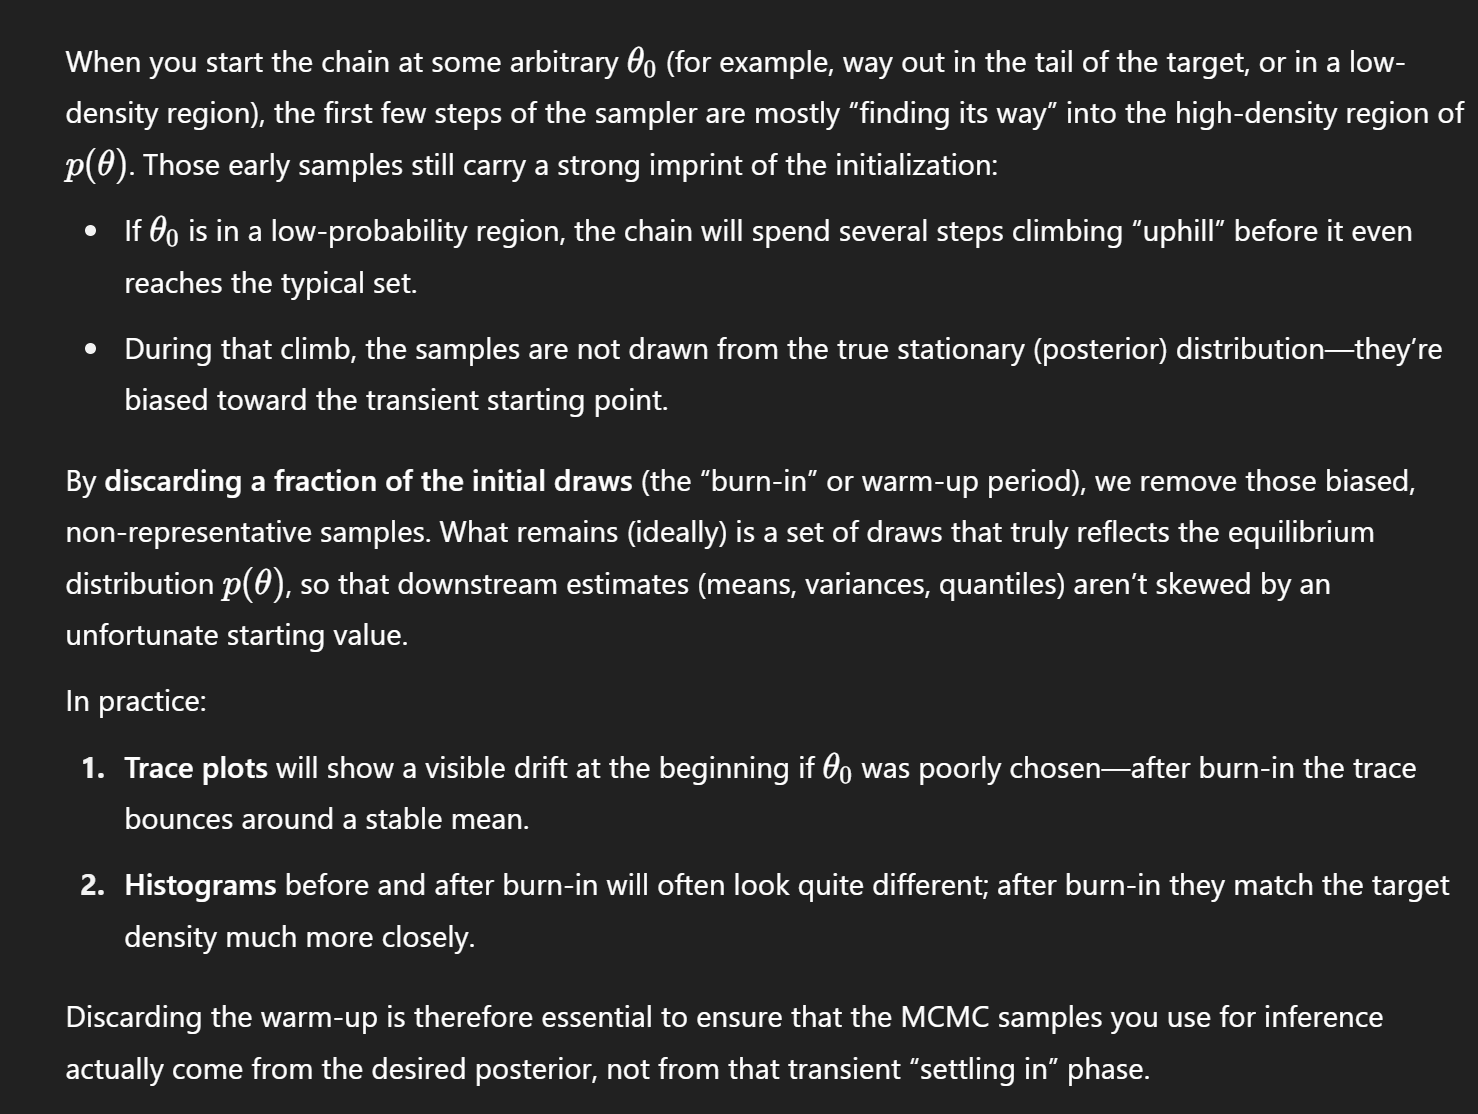
 


**Task 3.2**: Go back to the implementation of the `metropolis` function and make the function print the acceptance rate, i.e. the number of accepted samples divided by the total number of iterations.


**Task 3.3**: What happens to the acceptance ratio if you change the variance of the proposal distribution, e.g. $\tau = 0.1$, $\tau = 10$ or $\tau=500$? How well does the resulting histogram of the samples match the true target distribution? [**Discussion question**]

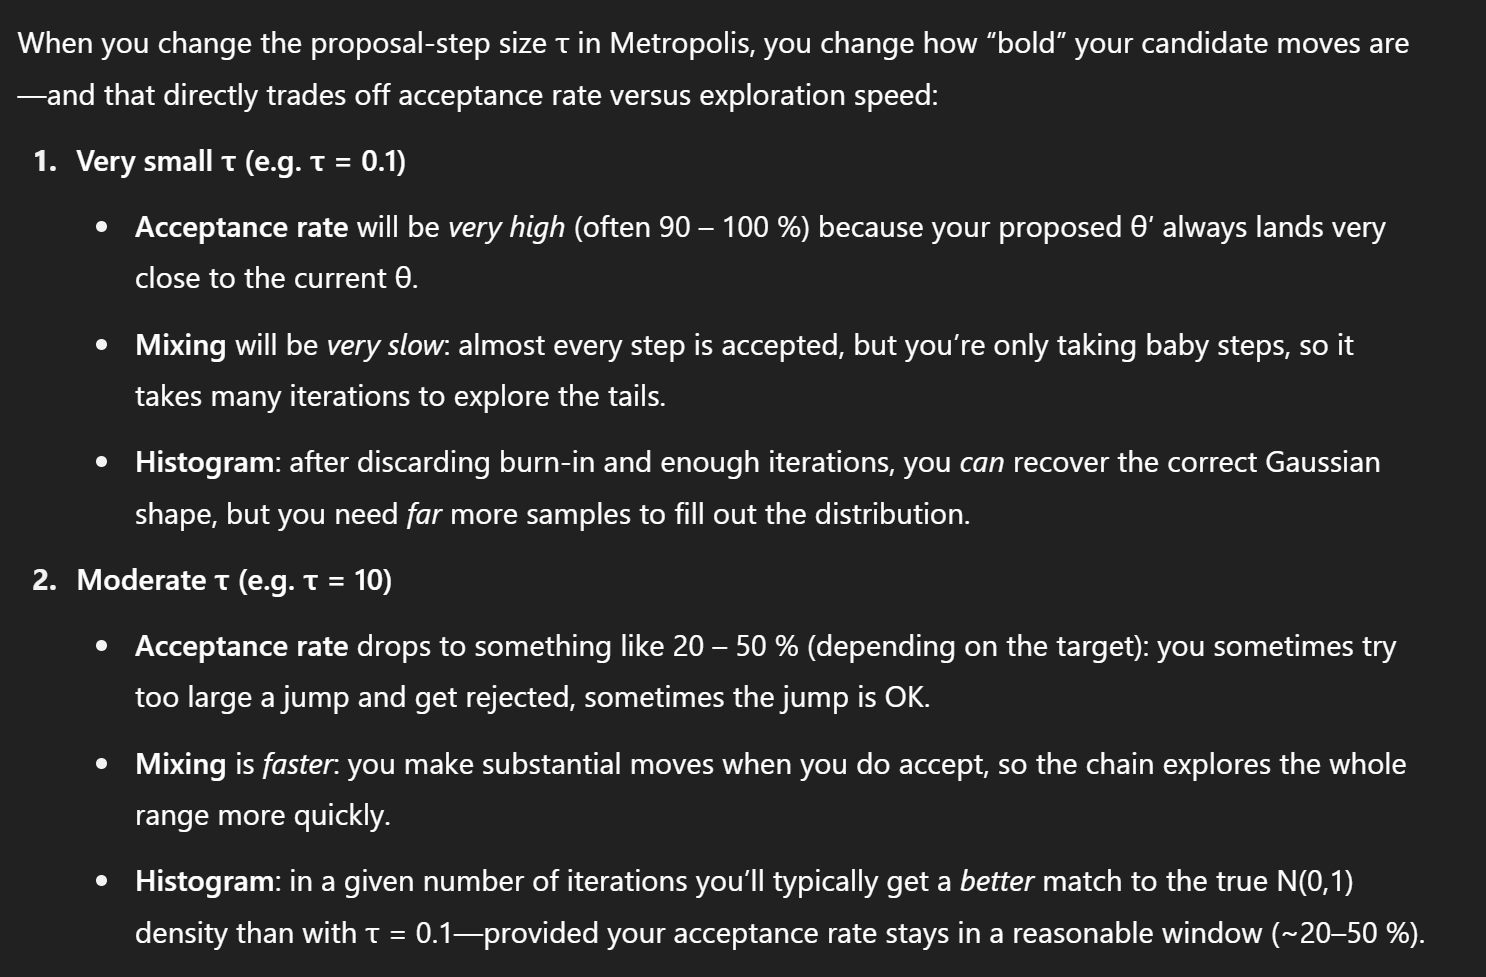
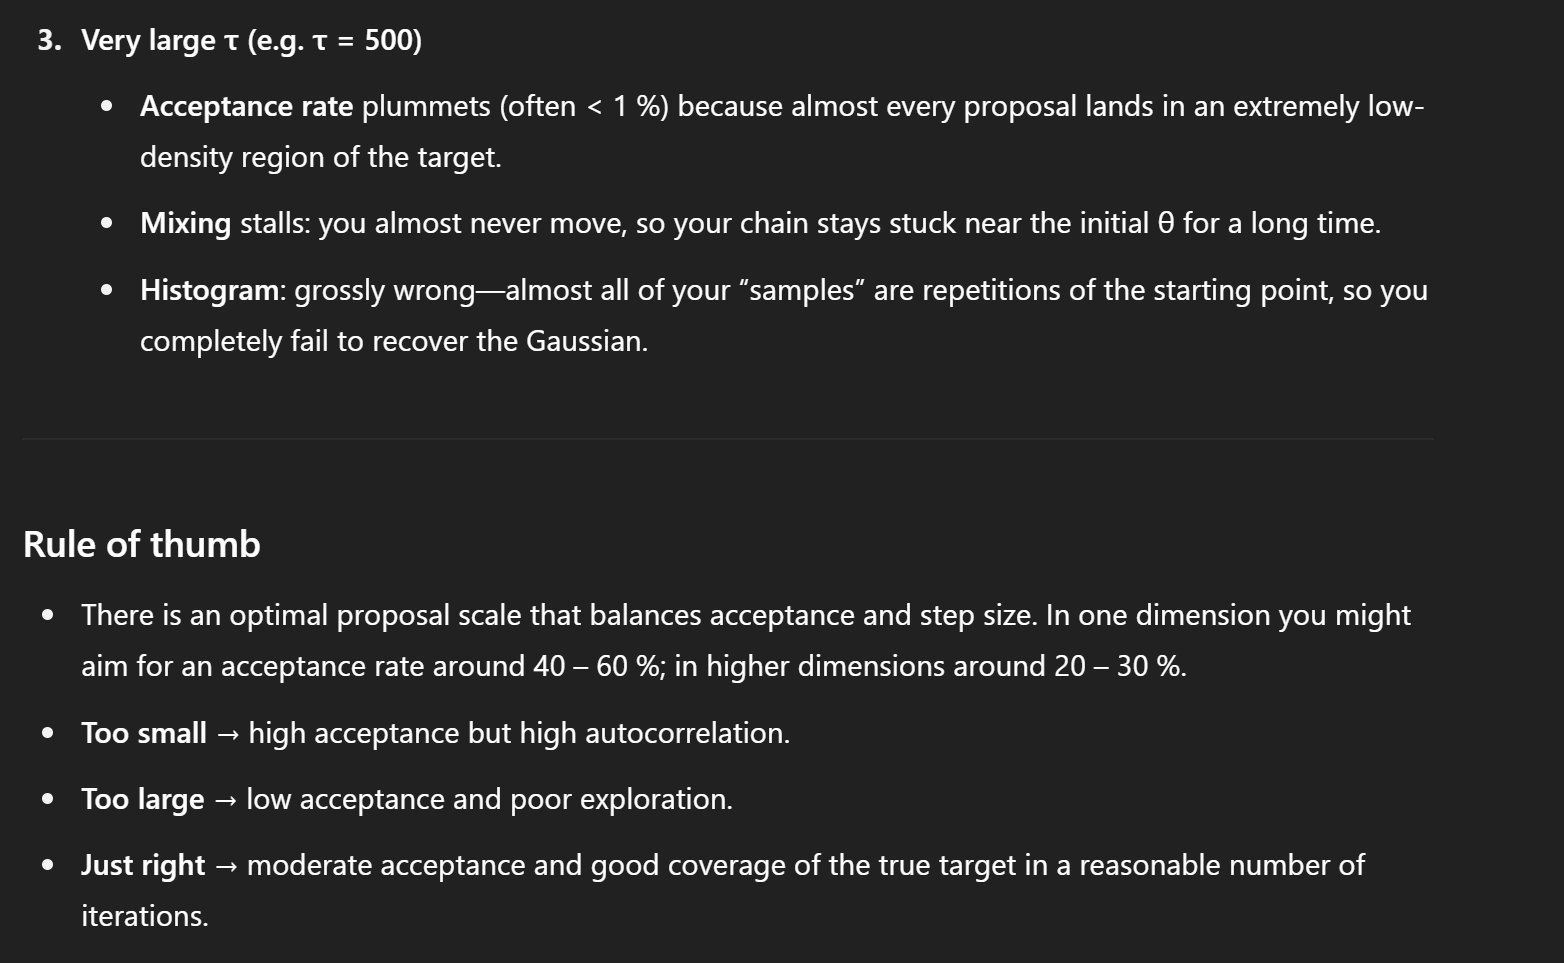

**Task 3.4**: Using $\tau = 0.5$ and keeping warm up at 50%, how many iterations do you need before distribution of the samples resembles the target distribution (based on a visual comparison of the target density and the histogram of the samples)? [**Discussion question**]

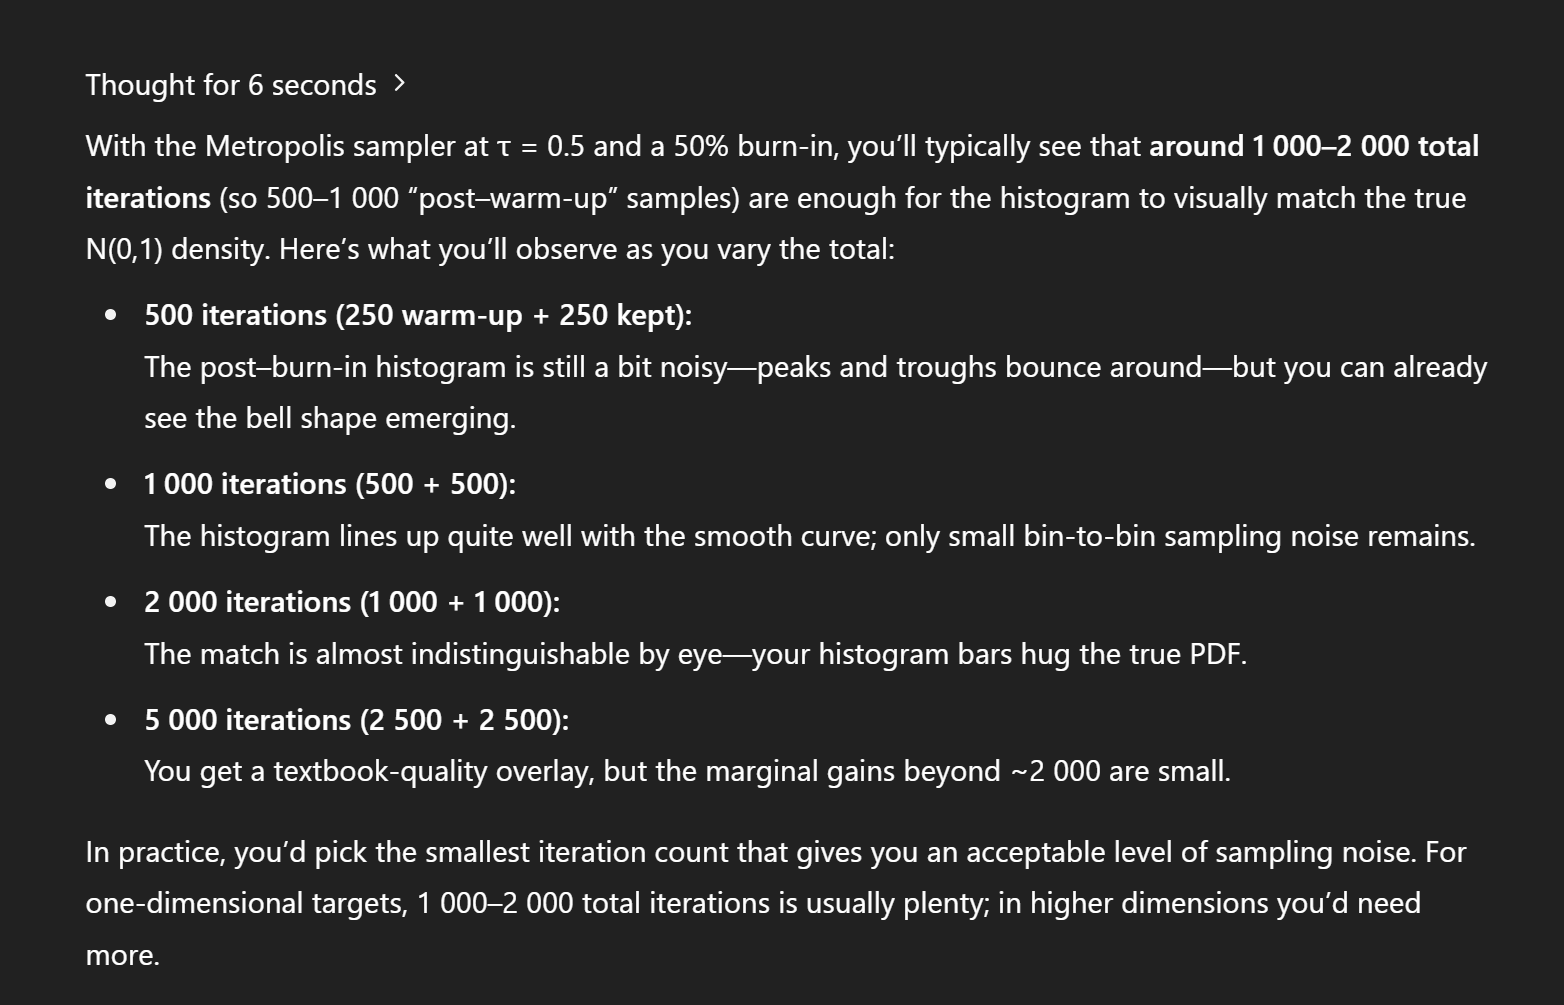


**Task 3.5**: Use the MH-algorithm to estimate the mean, the variance and the probability that $\theta > 1$ for the following two distributions given below. 

*Hints*
- *Plot the trace to verify that the chains appear to have converged. If not adapt the proposal variance and/or the number of samples*
- *Plot the target densities as well as the histogram of the resulting samples to verify that everything looks ok*


$$\begin{align*}
p(\theta) &\propto \exp(-|\theta-3|)\\
p(\theta) &= \frac{3}{40}\exp(-\frac12 |\theta-3|) + \frac{7}{20} \exp(-|\theta+2|)  \\
p(\theta) &= 2\phi(\theta)\Phi(5\theta),
\end{align*}$$


where $\phi(\cdot)$ and $\Phi(\cdot)$ is the PDF and CDF a standarized normal distribution, respectively. The first distributions in an instance of the family of [Laplace distributions](https://en.wikipedia.org/wiki/Laplace_distribution), the second is a mixture of Laplace distributions and the last distribution is an instance of the family of [skew-normal distributions](https://en.wikipedia.org/wiki/Skew_normal_distribution).



_____________________________________
**Task 3.5.1** Use the Metropolis-Hastings algorithm to sample to estimate the mean, variance and the probability that $\theta > 1$ for p($\theta$) $\propto exp(-|\theta-3|)$.

Acceptance ratio: 0.83


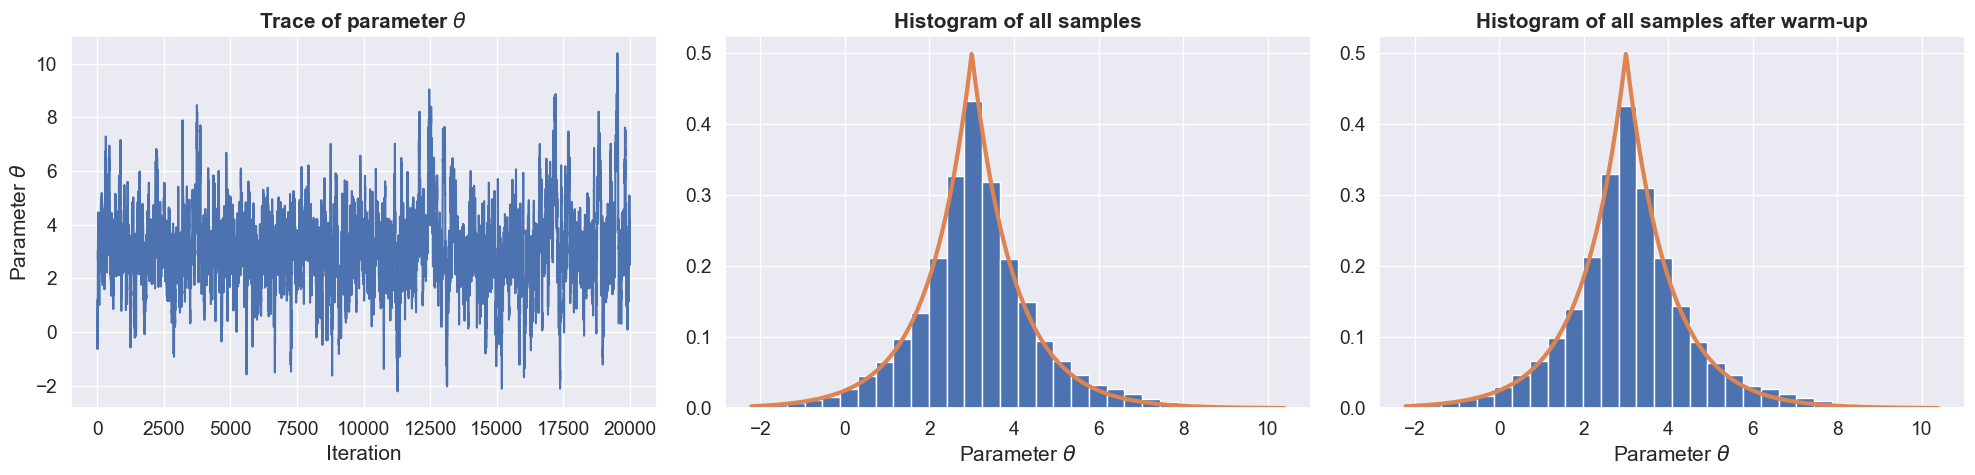

The mean of the MH samples is 3.12
The variance of the MH samples is 2.12
95%-interval:  [0.19 6.49]
True mean: 3.0
True variance: 2.0
Percentage of samples where theta > 1: 93.70%


In [8]:
from scipy.stats import loglaplace
from scipy.stats import laplace

# equation for log-laplace distribution
# log-laplace(x, m, c) = -log(2*c) - |x-m|/c
# where m = mean, c = scale parameter
# equation for laplace distrubtion 
# laplace(x, m, c) = 1/(2*c) * exp(-|x-m|/c)

c = 1.0 # shape parameter
loc = 3.0 # location parameter (m)
scale = 1.0 # scale parameter

num_params = 1 

num_iterations = 5000

warm_up = int(0.5*num_iterations)

tau = 0.5


log_laplace = lambda x: -jnp.log(2*c) - jnp.abs(x-loc)/c

thetas_laplace = metropolis(log_target=log_laplace, num_params=1, tau=0.5, num_iter=20000, theta_init=jnp.array([0]))

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].plot(thetas_laplace)             # Plot the sequence of samples stored in 'thetas'.
axes[0].set_xlabel('Iteration')  # Label the x-axis.
axes[0].set_ylabel('Parameter $\\theta$') # Label the y-axis (using LaTeX for the theta symbol).
axes[0].set_title('Trace of parameter $\\theta$', fontweight='bold') # Set the title for the first subplot.

axes[1].hist(thetas_laplace, 30, density=True); # Create a histogram of all values in 'thetas'.
                                        # '30' is the number of bins.
                                        # 'density=True' normalizes the histogram so its area integrates to 1,
                                        # allowing direct comparison with the probability density function.
xs = jnp.linspace(min(thetas_laplace), max(thetas_laplace), 1000)                                        
axes[1].plot(xs, laplace.pdf(xs, loc, scale), linewidth=3, label='True Laplace PDF') # Calculate the PDF by exponentiating the log-PDF.
                                                    # Plot it as a line over the histogram.
axes[1].set_xlabel('Parameter $\\theta$') # Label the x-axis.
axes[1].set_title('Histogram of all samples', fontweight='bold') # Set the title for the second subplot.

axes[2].hist(thetas_laplace[warm_up:], 30, density=True); # Create a histogram using only the samples *after* the warm_up index.
                                                 # thetas[warm_up:] slices the array to exclude the first 'warm_up' samples.
                                                 # Uses the same number of bins and normalization as Plot 2.

axes[2].plot(xs, laplace.pdf(xs, loc, scale), linewidth=3, label='True Laplace PDF')
axes[2].set_xlabel('Parameter $\\theta$'); # Label the x-axis.
axes[2].set_title('Histogram of all samples after warm-up', fontweight='bold'); # Set the title for the third subplot.

plt.tight_layout() # Adjusts subplot params for a tight layout.
plt.savefig('laplace_mcmc.png', dpi=300) # Save the figure as a PNG file with 300 DPI resolution.
plt.show();         # Displays the figure.



################################ MEAN, VARIANCE AND 95% INTERVAL ##########################################################

print(f"The mean of the MH samples is {jnp.mean(thetas_laplace):3.2f}")
print(f"The variance of the MH samples is {jnp.var(thetas_laplace):3.2f}")
print(f'95%-interval:  {np.array2string(jnp.percentile(thetas_laplace, jnp.array([2.5, 97.5])), precision=2)}')
print(f'True mean: {loc}') # mean of laplace distribution is loc
print(f'True variance: {2*c**2}') # equation for variance of laplace distribution is 2*c^2
##########################################################################################################################

##################### PROBABILITY OF THETA > 1 ###########################################################################

theta_above_one = jnp.mean(thetas_laplace > 1) * 100

print(f"Percentage of samples where theta > 1: {theta_above_one:.2f}%")

##########################################################################################################################
# alternative way and slower 
# Filter samples greater than 1
#theta_above_1 = thetas_laplace[thetas_laplace > 1]

# Calculate the percentage of samples greater than 1
#percentage_above_1 = len(theta_above_1) / len(thetas_laplace) * 100

# Print the percentage
#print(f"Percentage of samples where theta > 1: {percentage_above_1:.2f}%")


_____________________

**Task 3.5.1** Use the Metropolis-Hastings algorithm to sample to estimate the mean, variance and the probability that $\theta > 1$ for $p(\theta) = \frac{3}{40}\exp(-\frac12 |\theta-3|) + \frac{7}{20} \exp(-|\theta+2|)$

In [9]:
def laplace_mean_variance(mu, b):
  """Calculates the mean and variance of a Laplace distribution.

  Args:
    mu: The location parameter.
    b: The scale parameter (b > 0).

  Returns:
    A tuple containing the mean and variance.
  """
  mean = mu
  variance = 2 * (b**2)
  return mean, variance

# Parameters of the first Laplacian distribution
mu1 = 3
b1 = 1/2
weight1 = 3/40

# Parameters of the second Laplacian distribution
mu2 = -2
b2 = 1
weight2 = 7/20

# Calculate the mean and variance of each Laplacian component
mean1, var1 = laplace_mean_variance(mu1, b1)
mean2, var2 = laplace_mean_variance(mu2, b2)

# Calculate the mean of the mixture distribution
mixture_mean = weight1 * mean1 + weight2 * mean2

# Calculate the variance of the mixture distribution
mixture_variance = (weight1 * (var1 + mean1**2) +
                    weight2 * (var2 + mean2**2) -
                    mixture_mean**2)

print(f"Mean of the first Laplacian: {mean1}")
print(f"Variance of the first Laplacian: {var1}")
print(f"Weight of the first Laplacian: {weight1}")
print(f"Mean of the second Laplacian: {mean2}")
print(f"Variance of the second Laplacian: {var2}")
print(f"Weight of the second Laplacian: {weight2}")
print(f"Mean of the mixture distribution: {mixture_mean}")
print(f"Variance of the mixture distribution: {mixture_variance}")

Mean of the first Laplacian: 3
Variance of the first Laplacian: 0.5
Weight of the first Laplacian: 0.075
Mean of the second Laplacian: -2
Variance of the second Laplacian: 2
Weight of the second Laplacian: 0.35
Mean of the mixture distribution: -0.475
Variance of the mixture distribution: 2.5868749999999996


______________

Acceptance ratio: 0.87


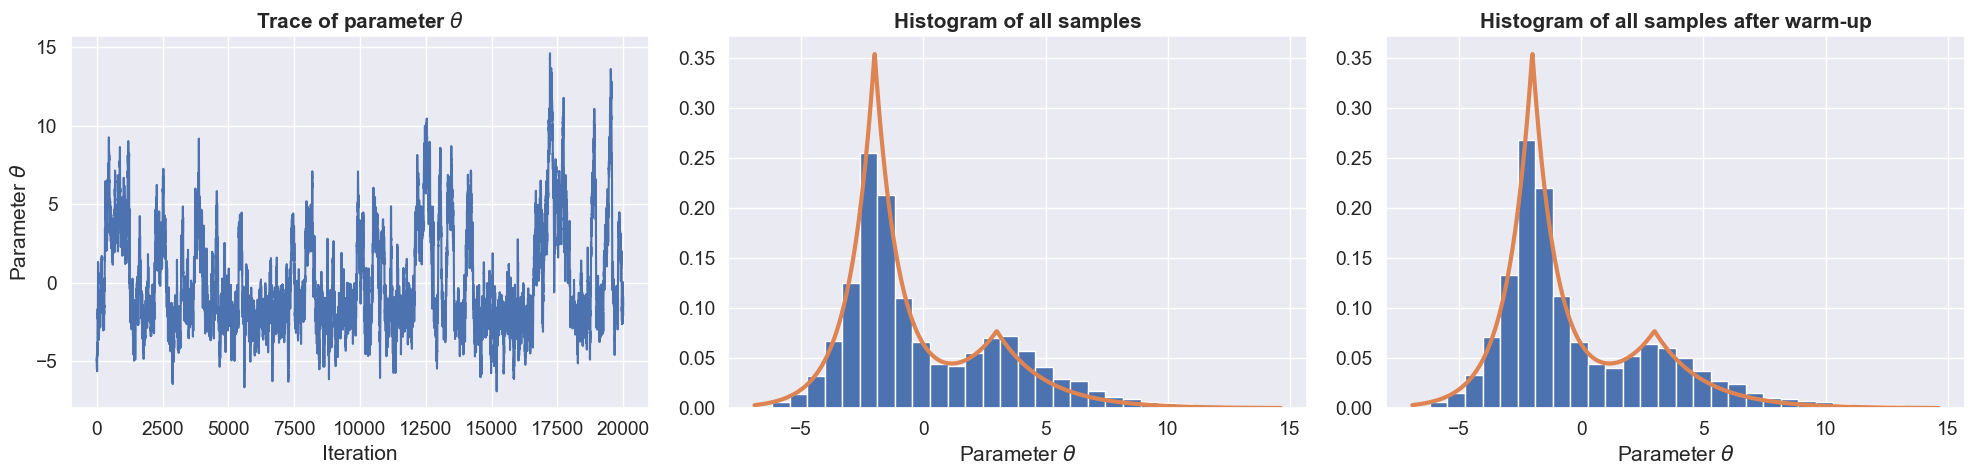

The mean of the MH samples is 0.09
The variance of the MH samples is 11.48
95%-interval:  [-4.4   8.14]
True mean: -0.475
True variance: 2.5868749999999996
Percentage of samples where theta > 1: 32.76%


In [10]:
# Define parameters for our mixture of Laplace distributions
# First component: centered at x = 3 with scale = 2
# Second component: centered at x = -2 with scale = 1
# Mixture weights: 30% for first component, 70% for second component
loc1, scale1, weight1 = 3, 2, 0.3
loc2, scale2, weight2 = -2, 1, 0.7

# Define the Laplace mixture PDF as a lambda function
laplace_mixture_pdf = lambda x: (weight1 / (2 * scale1)) * jnp.exp(-jnp.abs(x - loc1) / scale1) + (weight2 / (2 * scale2)) * jnp.exp(-jnp.abs(x - loc2) / scale2)

# Define the log version for use with the Metropolis-Hastings algorithm
log_laplace_mixture = lambda x: jnp.log(laplace_mixture_pdf(x))


num_params = 1 

num_iterations = 5000

warm_up = int(0.5*num_iterations)


thetas_laplace_mixture = metropolis(log_target=log_laplace_mixture, num_params=1, tau=0.5, num_iter=20000, theta_init=jnp.array([-5]))



fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].plot(thetas_laplace_mixture)             # Plot the sequence of samples stored in 'thetas'.
axes[0].set_xlabel('Iteration')  # Label the x-axis.
axes[0].set_ylabel('Parameter $\\theta$') # Label the y-axis (using LaTeX for the theta symbol).
axes[0].set_title('Trace of parameter $\\theta$', fontweight='bold') # Set the title for the first subplot.

axes[1].hist(thetas_laplace_mixture, 30, density=True); # Create a histogram of all values in 'thetas'.
                                        # '30' is the number of bins.
                                        # 'density=True' normalizes the histogram so its area integrates to 1,
                                        # allowing direct comparison with the probability density function.
xs = jnp.linspace(min(thetas_laplace_mixture), max(thetas_laplace_mixture), 1000)                                        
axes[1].plot(xs, laplace_mixture_pdf(xs), linewidth=3, label='True Laplace PDF') # Calculate the PDF by exponentiating the log-PDF.
                                                    # Plot it as a line over the histogram.
axes[1].set_xlabel('Parameter $\\theta$') # Label the x-axis.
axes[1].set_title('Histogram of all samples', fontweight='bold') # Set the title for the second subplot.

axes[2].hist(thetas_laplace_mixture[warm_up:], 30, density=True); # Create a histogram using only the samples *after* the warm_up index.
                                                 # thetas[warm_up:] slices the array to exclude the first 'warm_up' samples.
                                                 # Uses the same number of bins and normalization as Plot 2.

axes[2].plot(xs, laplace_mixture_pdf(xs), linewidth=3, label='True Laplace PDF')
axes[2].set_xlabel('Parameter $\\theta$'); # Label the x-axis.
axes[2].set_title('Histogram of all samples after warm-up', fontweight='bold'); # Set the title for the third subplot.

plt.tight_layout() # Adjusts subplot params for a tight layout.
plt.savefig('laplace_mcmc.png', dpi=300) # Save the figure as a PNG file with 300 DPI resolution.
plt.show();         # Displays the figure.



################################ MEAN, VARIANCE AND 95% INTERVAL ##########################################################

print(f"The mean of the MH samples is {jnp.mean(thetas_laplace_mixture):3.2f}")
print(f"The variance of the MH samples is {jnp.var(thetas_laplace_mixture):3.2f}")
print(f'95%-interval:  {np.array2string(jnp.percentile(thetas_laplace_mixture, jnp.array([2.5, 97.5])), precision=2)}')
print(f'True mean: {mixture_mean}') # mean of laplace distribution is loc
print(f'True variance: {mixture_variance}') # equation for variance of laplace distribution is 2*c^2
##########################################################################################################################

##################### PROBABILITY OF THETA > 1 ###########################################################################

theta_above_one = jnp.mean(thetas_laplace_mixture > 1) * 100

print(f"Percentage of samples where theta > 1: {theta_above_one:.2f}%")

##########################################################################################################################
# alternative way and slower 
# Filter samples greater than 1
#theta_above_1 = thetas_laplace[thetas_laplace > 1]

# Calculate the percentage of samples greater than 1
#percentage_above_1 = len(theta_above_1) / len(thetas_laplace) * 100

# Print the percentage
#print(f"Percentage of samples where theta > 1: {percentage_above_1:.2f}%")


__________
**Task 3.5.3** Use the Metropolis-Hastings algorithm to sample to estimate the mean, variance and the probability that $\theta > 1$ for $p(\theta) = 2\phi(\theta)\Phi(5\theta)$

Acceptance ratio: 0.54


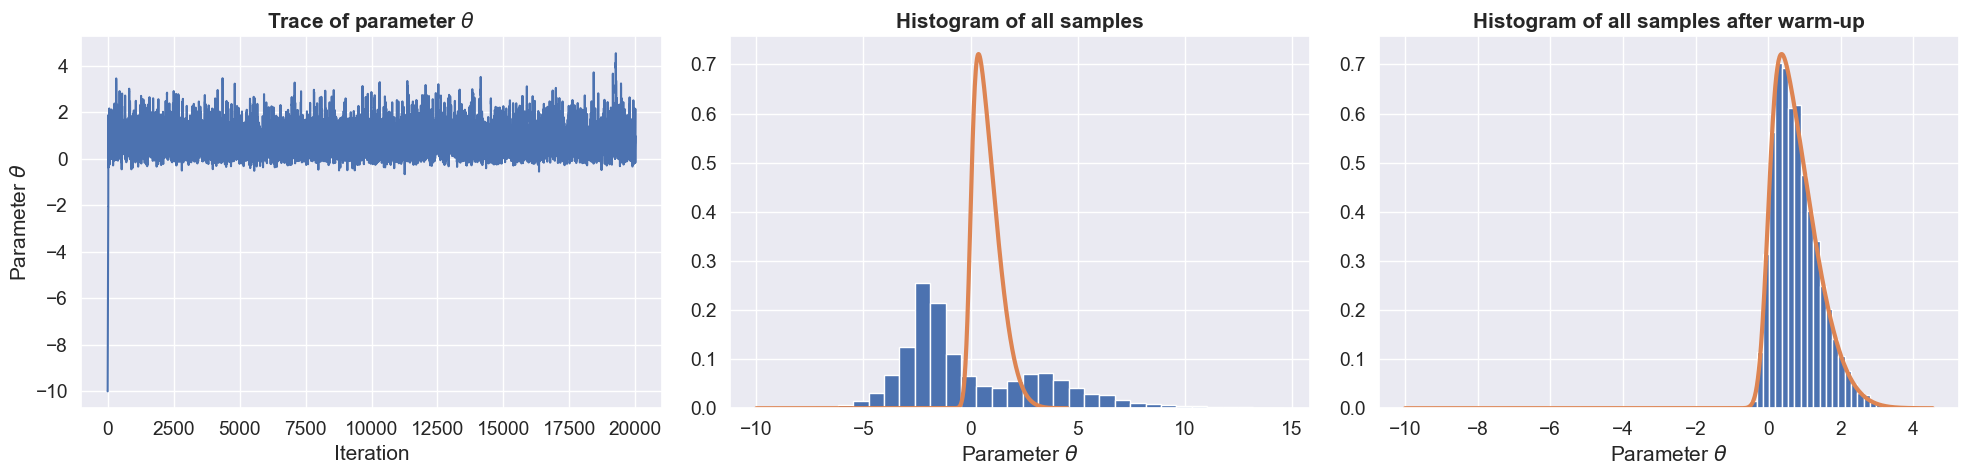

The mean of the MH samples is 0.79
The variance of the MH samples is 0.47
95%-interval:  [-0.14  2.28]
Percentage of samples where theta > 1: 32.27%


In [11]:
from scipy.stats import norm

num_params = 1 

num_iterations = 5000

warm_up = int(0.5*num_iterations)

tau = 0.5
  
pdf_cdf = lambda x: 2 * norm.pdf(x) * norm.cdf(5 * x)

log_pdf_log_cdf = lambda x : jnp.log(2) + norm.logpdf(x) + norm.logcdf(5 * x)

thetas_log_pdf_log_cdf = metropolis(log_target=log_pdf_log_cdf, num_params=1, tau=1, num_iter=20000, theta_init=jnp.array([-10]))

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].plot(thetas_log_pdf_log_cdf)             # Plot the sequence of samples stored in 'thetas'.
axes[0].set_xlabel('Iteration')  # Label the x-axis.
axes[0].set_ylabel('Parameter $\\theta$') # Label the y-axis (using LaTeX for the theta symbol).
axes[0].set_title('Trace of parameter $\\theta$', fontweight='bold') # Set the title for the first subplot.

axes[1].hist(thetas_laplace_mixture, 30, density=True); # Create a histogram of all values in 'thetas'.
                                        # '30' is the number of bins.
                                        # 'density=True' normalizes the histogram so its area integrates to 1,
                                        # allowing direct comparison with the probability density function.
xs = jnp.linspace(min(thetas_log_pdf_log_cdf), max(thetas_log_pdf_log_cdf), 1000)                                        
axes[1].plot(xs, pdf_cdf(xs), linewidth=3, label='True Laplace PDF') # Calculate the PDF by exponentiating the log-PDF.
                                                    # Plot it as a line over the histogram.
axes[1].set_xlabel('Parameter $\\theta$') # Label the x-axis.
axes[1].set_title('Histogram of all samples', fontweight='bold') # Set the title for the second subplot.

axes[2].hist(thetas_log_pdf_log_cdf[warm_up:], 30, density=True); # Create a histogram using only the samples *after* the warm_up index.
                                                 # thetas[warm_up:] slices the array to exclude the first 'warm_up' samples.
                                                 # Uses the same number of bins and normalization as Plot 2.

axes[2].plot(xs, pdf_cdf(xs), linewidth=3, label='True Laplace PDF')
axes[2].set_xlabel('Parameter $\\theta$'); # Label the x-axis.
axes[2].set_title('Histogram of all samples after warm-up', fontweight='bold'); # Set the title for the third subplot.

plt.tight_layout() # Adjusts subplot params for a tight layout.
plt.savefig('laplace_mcmc.png', dpi=300) # Save the figure as a PNG file with 300 DPI resolution.
plt.show();         # Displays the figure.



################################ MEAN, VARIANCE AND 95% INTERVAL ##########################################################

print(f"The mean of the MH samples is {jnp.mean(thetas_log_pdf_log_cdf):3.2f}")
print(f"The variance of the MH samples is {jnp.var(thetas_log_pdf_log_cdf):3.2f}")
print(f'95%-interval:  {np.array2string(jnp.percentile(thetas_log_pdf_log_cdf, jnp.array([2.5, 97.5])), precision=2)}')
#print(f'True mean: {loc}') # mean of laplace distribution is loc
#print(f'True variance: {2*c**2}') # equation for variance of laplace distribution is 2*c^2
##########################################################################################################################

##################### PROBABILITY OF THETA > 1 ###########################################################################

theta_above_one = jnp.mean(thetas_log_pdf_log_cdf > 1) * 100

print(f"Percentage of samples where theta > 1: {theta_above_one:.2f}%")

##########################################################################################################################
# alternative way and slower 
# Filter samples greater than 1
#theta_above_1 = thetas_laplace[thetas_laplace > 1]

# Calculate the percentage of samples greater than 1
#percentage_above_1 = len(theta_above_1) / len(thetas_laplace) * 100

# Print the percentage
#print(f"Percentage of samples where theta > 1: {percentage_above_1:.2f}%")


____

#### The Metropolis-Hastings algorithm for 2D problems

Next, we will apply MH algorithm to generate samples from a bivariate normal distribution with correlation $\rho$. That is, the target density is

\begin{align*}
p(\mathbf{\theta}) = \mathcal{N}(\mathbf{\theta}|\mu, \Sigma),
\end{align*}

where $\mathbf{\theta} \in \mathbb{R}^2$, $\mathbf{\mu} = \begin{bmatrix}-4\\ 4\end{bmatrix}$, and $\mathbf{\Sigma} = \begin{bmatrix}1 & \rho \\ \rho & 1\end{bmatrix}$.

There are, of course, much more efficient ways to generate samples from multivarate normal distributions, but here we use the multivariate normal distribution to understand the properties of the MH algorithm.

Shape of theta init (2,) is the same as a number of parameters 2
Acceptance ratio: 0.75
Mean and variance of samples for theta1: -3.85, 0.97
The relative error of the mean and variance is -0.04, -0.03
Mean and variance of samples for theta2: 3.93, 1.16
The relative error of the mean and variance is -0.02, 0.16


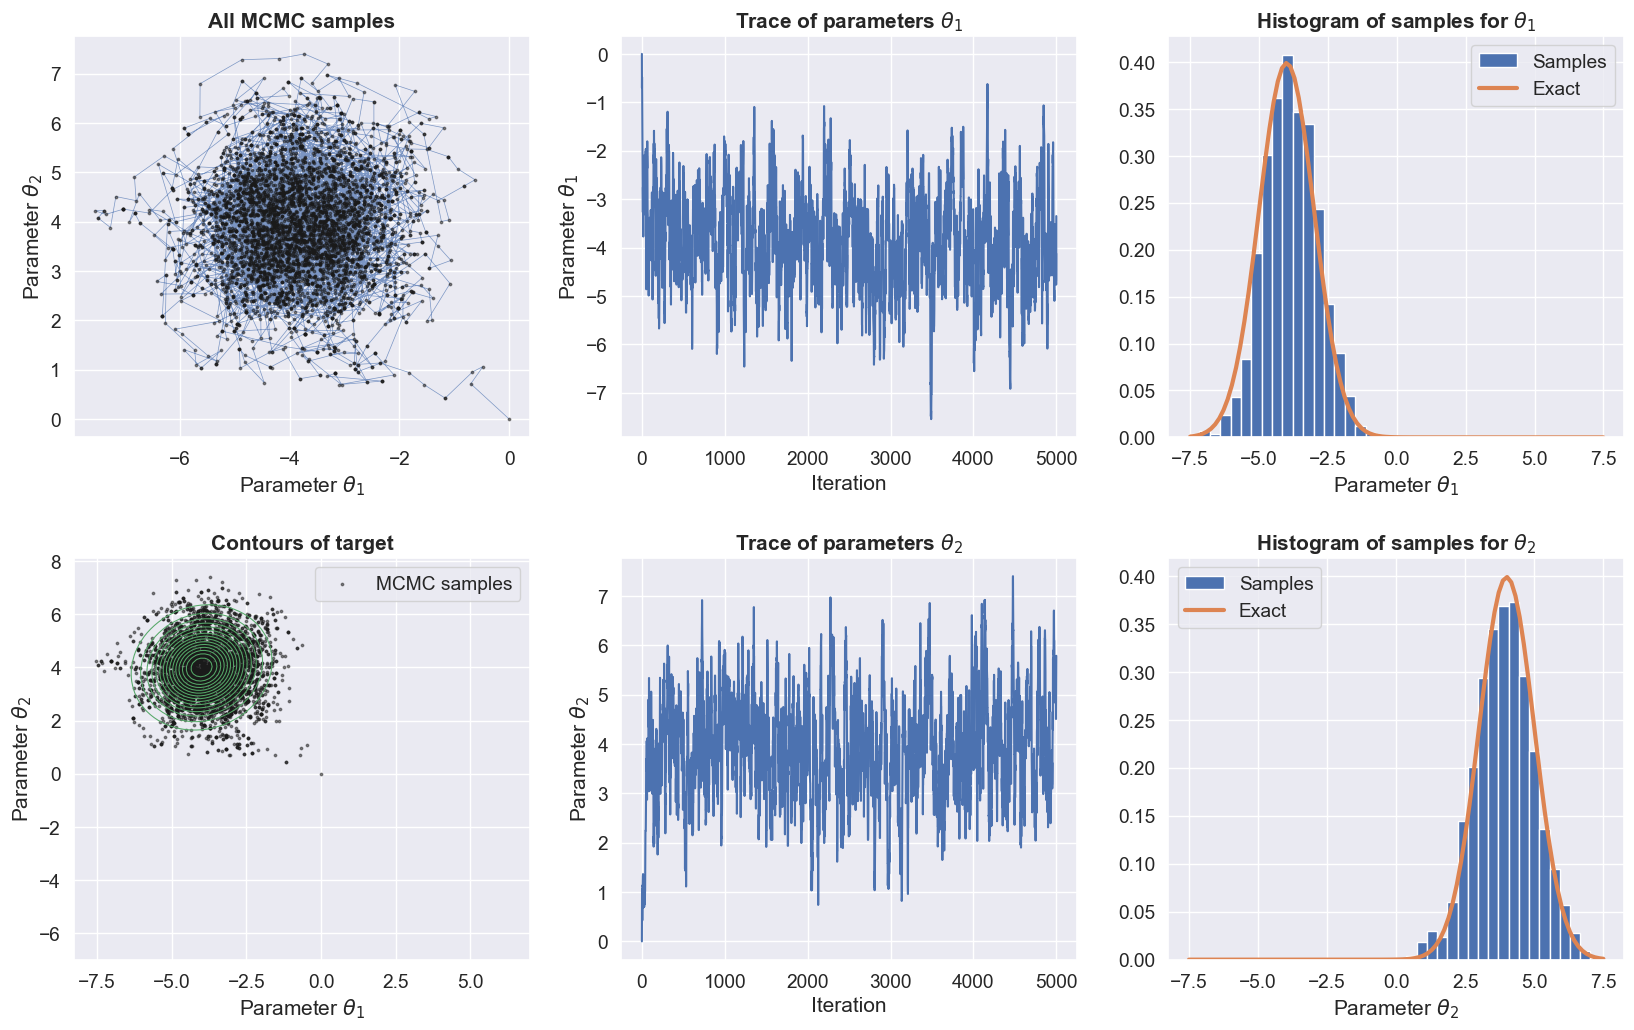

In [12]:
# specify target density
mu = jnp.array([-4, 4])                            # mean vector of shape (2,)
rho = 0.1                                         # correlation coefficient (scalar)
S = jnp.array([[1, rho], [rho, 1]])                # covariance matrix of shape (2, 2)
log_joint = lambda x: mvn.logpdf(x, mu, S)        # target density (log PDF): takes input of shape (2,) and returns scalar

# sampler settings
num_params = 2                       # dimensionality of the parameter space
num_iterations = 5000                # total number of MCMC iterations
warm_up = int(0.5*num_iterations)    # discard the first 50% of samples as burn-in
tau = 0.5                            # proposal distribution standard deviation (step size)

# run Metropolis-Hastings sampler
# returns: thetas - array of shape (num_iterations+1, num_params)
thetas = metropolis(log_joint, num_params, tau, num_iterations, seed=0)

# Create a grid of x values for plotting PDFs
xs = jnp.linspace(-7.5, 7.5, 100)    # shape: (100,)

# Set up figure with 2 rows, 3 columns of subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Plot 1: Scatter plot of all samples in the parameter space
axes[0, 0].plot(*thetas.T, lw=0.5, alpha=0.7, zorder=1)    # Plot path of the chain
axes[0, 0].scatter(*thetas.T, c="k", s=3, alpha=0.5, zorder=2)    # Scatter plot of samples
axes[0, 0].set_xlabel('Parameter $\\theta_1$')
axes[0, 0].set_ylabel('Parameter $\\theta_2$')
axes[0, 0].set_title('All MCMC samples', fontweight='bold')

# Plot 2: Contour plot of the target distribution with samples
x_grid, log_density_grid = eval_density_grid(log_joint)    # Create grid for contour plot
                                                          # x_grid shape: (100,), log_density_grid: (100, 100)
axes[1, 0].scatter(*thetas.T, c="k", s=3, alpha=0.5, label='MCMC samples')
axes[1, 0].contour(x_grid, x_grid, jnp.exp(log_density_grid), levels=15, linewidths=0.75, colors='g')
axes[1, 0].set_xlabel('Parameter $\\theta_1$')
axes[1, 0].set_ylabel('Parameter $\\theta_2$')
axes[1, 0].set_title('Contours of target', fontweight='bold')
axes[1, 0].legend()

# Create trace plots and histogram plots for each parameter
for i in range(2):
    # Trace plot: shows parameter value vs iteration
    axes[i, 1].plot(thetas[:, i])    # Plot values over time for parameter i
    axes[i, 1].set_title('Trace of parameters $\\theta_{%d}$' % (i+1), fontweight='bold')
    axes[i, 1].set_xlabel('Iteration')
    axes[i, 1].set_ylabel('Parameter $\\theta_{%d}$' % (i+1))
    
    # Histogram of samples with true marginal PDF overlay
    axes[i, 2].hist(thetas[:, i], 20, density=True, label='Samples')    # Histogram of samples
    axes[i, 2].set_xlabel('Parameter $\\theta_{%d}$' % (i+1))
    axes[i, 2].plot(xs, npdf(xs, mu[i], S[i,i]), linewidth=3, label='Exact')    # Plot true marginal PDF
    axes[i, 2].set_title('Histogram of samples for $\\theta_{%d}$' % (i+1), fontweight='bold')
    axes[i, 2].legend()
    
    # Print estimated mean and variance for each parameter
    print(f"Mean and variance of samples for theta{i+1}: {jnp.mean(thetas[:, i]):.2f}, {jnp.var(thetas[:, i]):.2f}")
    print(f"The relative error of the mean and variance is {(jnp.mean(thetas[:, i]) - mu[i])/mu[i]:.2f}, {(jnp.var(thetas[:, i]) - S[i,i])/S[i,i]:.2f}")
    
# Adjust spacing between subplots
fig.subplots_adjust(hspace=0.3)


**Task 3.6**: Experiment with the number of iterations. How many iterations do you need before the sample mean and variance are equal to the true values (up to, say, 5%-10% relative error)? [**Discussion question**]

## Convergence to stationary distribution 
- The M-H creates a Markov chain, whose stationary distribution is the traget distribution (specified in log_joint).
- Meaning, that if we run the chain long enough, the samples it generates will look increasingly like samples drawn directly from the true target distribution. 
- The initial "warm-up" period is intented to give the chain time to forget its starting point and converge to the stationary distribution.

## Ergodic Theorem / Law of Large Numbers for Markov Chains
- Similar to the LLN for i.i.d. samples, the ergodic theorem states that the average of the samples generated by a Markov chain converges to the expected value of the target distribution as the number of samples goes to infinity.
- **For the mean:** The function is simply the identity function, i.e. *f(\theta) = theta*. So, the sample mean (1/N) \sum_{i=1}^N \theta_i converges to the true mean E[\theta] as N \to \infty.
- **For the variance:** The sample variance is also an average related to *theta* and *theta^2*. As N \to \infty, the sample variance converges to the true variance of the true Var(\theta).

## Summary

- A short run (like 1000 iterations) might not fully capture the shape and spread of the distribution, especially if it gets temporarily stuck or hasn't visited less probable areas sufficiently.




**Task 3.7**: What happens to the acceptance ratio if you increase the correlation in the target density to, say, $\rho = 0.7$, $\rho=0.9$, $\rho=0.95$ or $\rho=0.99$? What happens to the accuracy of the moments? [**Discussion question**]

#### $rho = 0.1$ acceptance ratio = 0.76
- 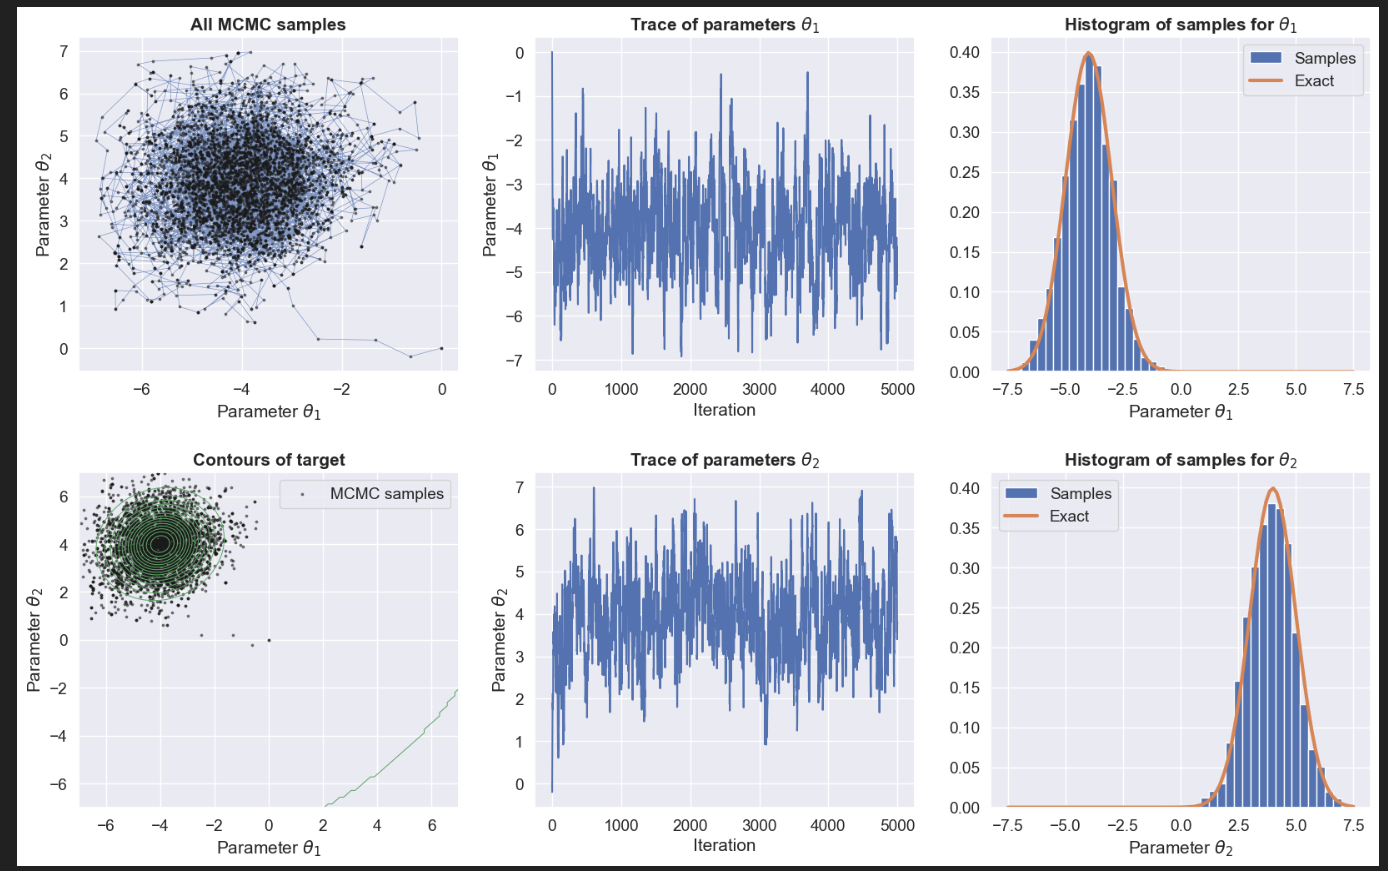

#### $\rho = 0.7$ acceptance ratio = 0.68
- 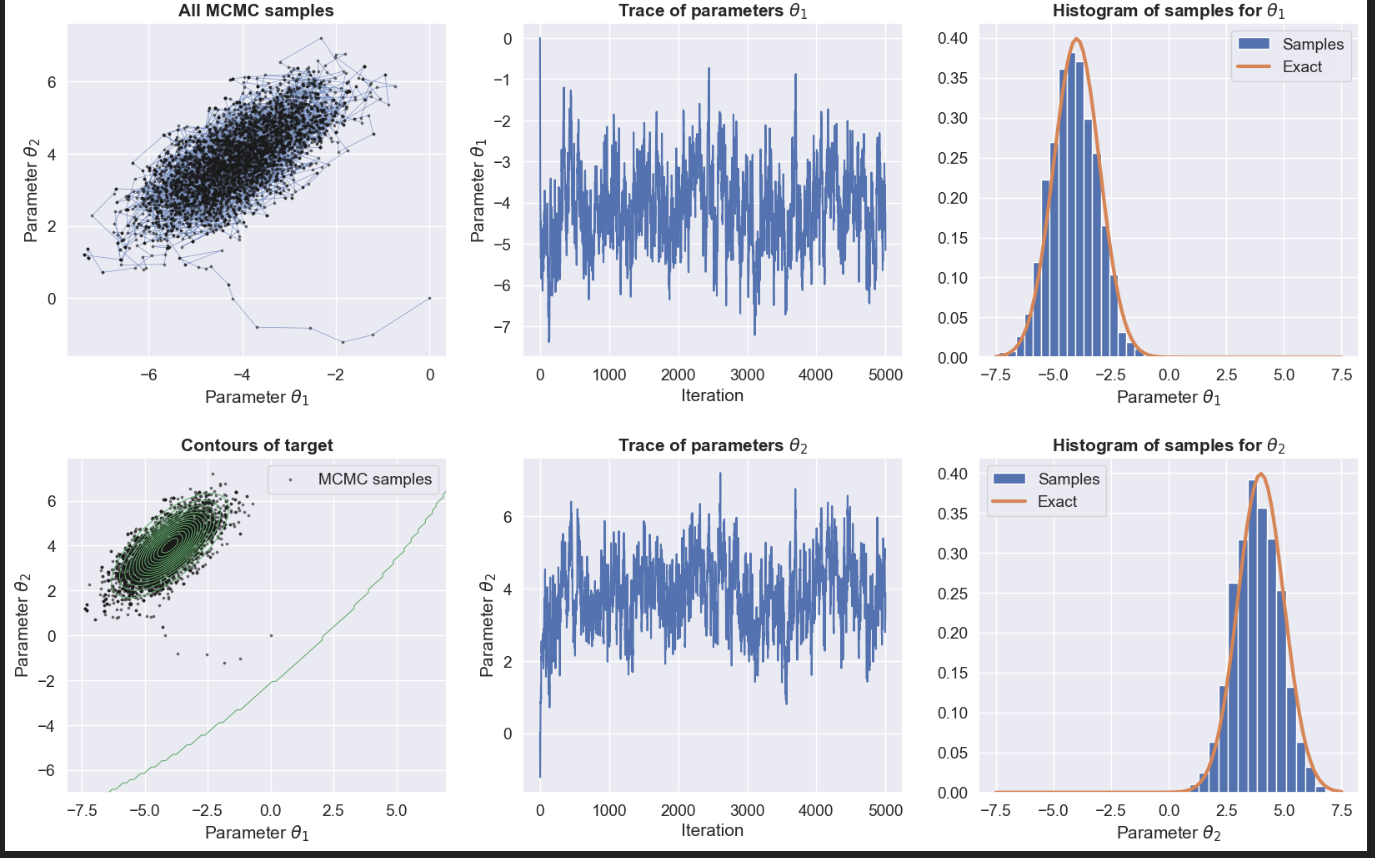

#### $\rho = 0.9$ acceptance ratio = 0.55
- 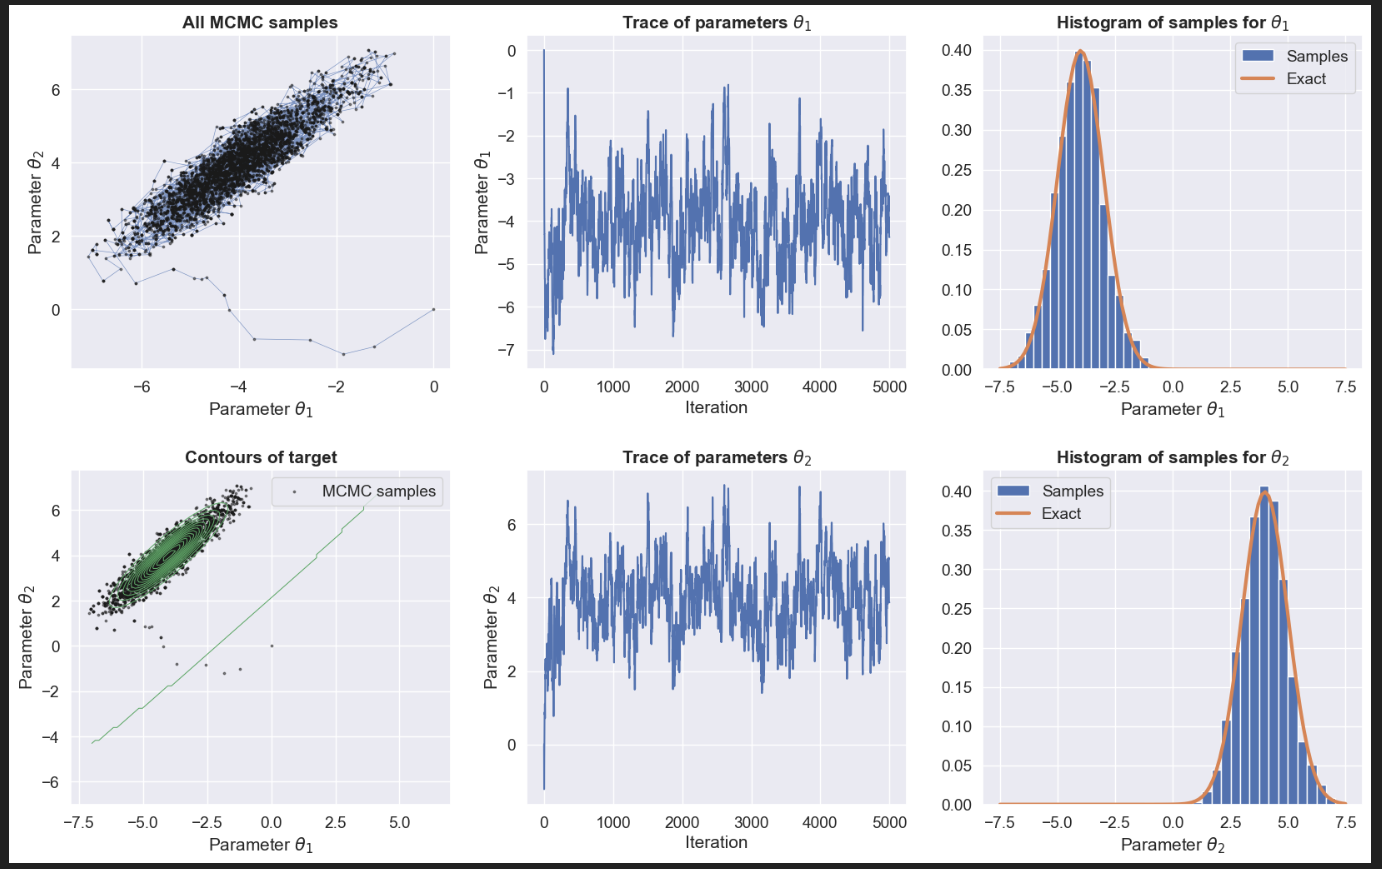

#### $\rho = 0.95$ acceptance ratio = 0.46
- 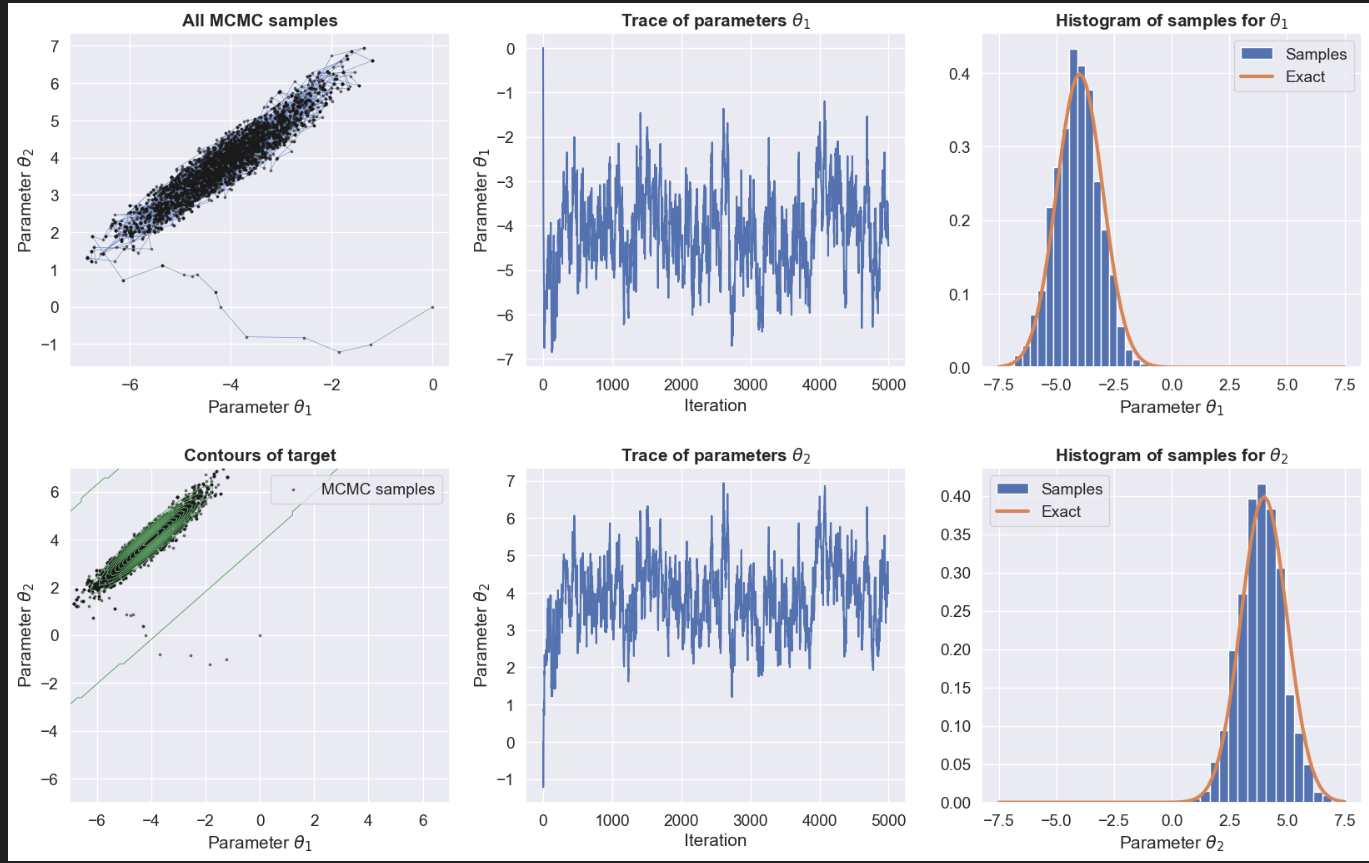

#### $\rho = 0.99$ acceptance ratio = 0.24

- 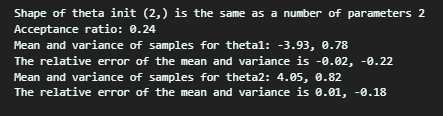


# What is happening? 

## Shape of the target distribution
- As we incrase the correlation coefficient $\rho$, the acceptance ratio decreases. We know, that the higher the $rho$, the more correlated the two dimensions are. 
- The distribution becomes highly ellongated and concentrated along a narrow diagonal ridge. The higher the correlation, the narrower this ridge of high probability density becomes. 

## Proposal mechanism 
- We have **isotropic** proposal distribution, meaning that the proposal distribution is the same in all directions. We add a random noise with variance $\tau^2$ to the current sample (in both directions). 
  - This means that it takes equal probability steps in all directions, meaning that when we have high correlation between the two dimensions, the proposal distribution is not aligned with the target distribution, and the proposal distribution will often be far away from the target distribution.    
  - Therefore some proposed steps will fall "of the ridge" into regions of much lower probability density compared to a current point. 
## Acceptance probability
- The acceptance probability is min(1, r_k), where r_k is p(theta^star) / p(theta^k-1). If he proposal point has much lower probability density, than the current point (because it fell of the ridge), the ratio p(theta^star) / p(theta^k-1) will be very small, and the acceptance probability will be low.

## Conclusion
- The more correlated the two dimensions are, the more difficult it is for the proposal distribution to explore the target distribution, and the lower the acceptance ratio becomes.

# Poor mixing
- A low acceptance ratio (like 0.24 for rho = 0.99) indicates that the sampler is inefficeint. It is rejecting most proposals. This leads to poor mixing. 
- The chain struggles to move effectively along the narrow ridge of the target distribution. 
  - It might take many small, accepted steps without moving far or frequently propose steps off the ridge that gets rejected. 
- The consecutive steps (theta_i), (theta_i+1), become highly correlated with each other. 
- This can also be observed in the trace plot of the samples, where the samples are clustered together and do not explore the parameter space effectively.


## Part 4:  Metroplis-Hastings for Bayesian Poisson regression

Now we will apply the Metropolis-Hastings algorithm to Bayesian Poisson regression (discussed in week 7). As a case study, we will use a small data set from a study on mortality (Broffiti, 1988), where the authors looked at the mortality rates as a function of age. 

Let's look at the data.

Shape of X_train: (30, 2)
Shape of X_train: (30, 2)


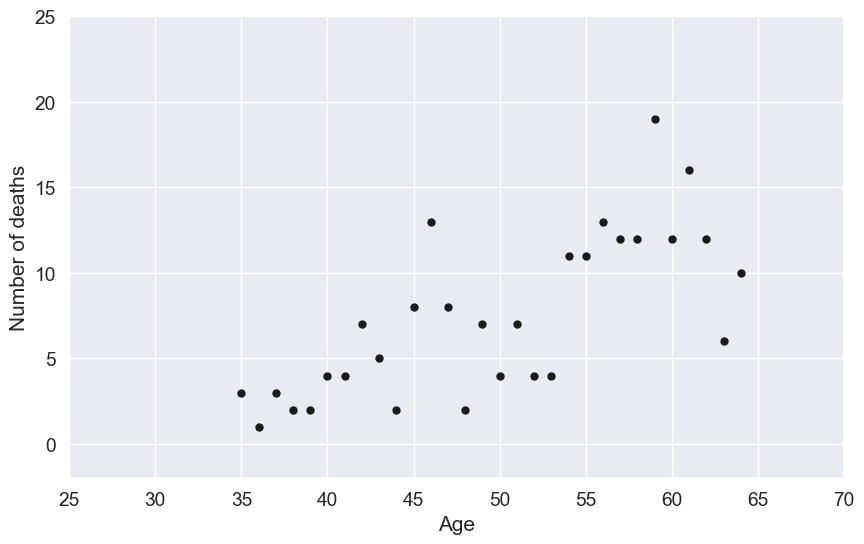

In [13]:
###################################################
# Raw data
###################################################

# The input covariate (independent variable) is age.
# Create a JAX array representing the ages from 35 up to (but not including) 65.
# Shape: (30,) - representing 30 distinct age groups (65 - 35 = 30).
# .astype(jnp.float64) ensures the data type is 64-bit float.
age = jnp.arange(35, 65).astype(jnp.float64)

# The output (dependent variable) is the number of deaths recorded for each corresponding age group in the study population.
# Create a JAX array containing these counts.
# Shape: (30,) - one death count for each age group.
# .astype(jnp.float64) converts the integer counts to 64-bit float, often done for consistency or compatibility with certain models.
deaths = jnp.array([3, 1, 3, 2, 2, 4, 4, 7, 5, 2, 8, 13, 8, 2, 7, 4, 7, 4, 4, 11, 11, 13, 12, 12, 19, 12, 16, 12, 6, 10]).astype(jnp.float64)

# Get the total number of data points (observations).
# N = 30
N = len(deaths)


###############################################

###################### Standardization ######################
# Let's standardize the input covariate 'age'.
# Standardization (calculating z-scores) centers the data around 0 and scales it by its standard deviation.
# This often improves numerical stability and performance of statistical models and optimization algorithms.
# Equation: x_standardized = (x - mean(x)) / std(x)
# Calculate the mean of the original 'age' array.
# Shape: () (scalar)
m_age = jnp.mean(age)
# Calculate the standard deviation of the original 'age' array.
# Shape: () (scalar)
s_age = jnp.std(age)

# Define a lambda function to perform the standardization using the calculated mean and std dev.
# It takes an array `x` and returns the standardized version.
standardize = lambda x: (x - m_age) / s_age

# Apply the standardization function to the 'age' data.
# 'x' now contains the standardized age values.
# Shape: (30,)
x = standardize(age)

#################################################################################

###################### Prepare for Linear Regression ############################

# Reshape the standardized 'x' array into a column vector (a 2D array with one column).
# required for linear algebra operations, treating each standardized age as a feature vector.
# The `[:, None]` syntax adds a new dimension of size 1.
# Shape: (30, 1)
x = x[:, None]

# Define input points for generating predictions later.
# Create an array of 100 evenly spaced age values between 25 and 70 (inclusive).
# These points will be used to plot the model's predictions across a relevant age range.
# Shape: (100,)
age_star = jnp.linspace(25, 70, 100)

# Standardize these new 'age_star' points using the *same* mean (m_age) and standard deviation (s_age)
# derived from the *original training data*. This is crucial for consistent scaling.
# 'x_star' contains the standardized ages for prediction.
# Shape: (100,)
x_star = standardize(age_star)

# Let's set-up the design matrix for the training data and the inputs for predictions.
# A design matrix is commonly used in linear models. It typically includes a column of ones
# (for the intercept/bias term) and columns for each input feature.
# For a simple linear model y ≈ β₀ + β₁*x, the design matrix X would be [1, x],
# allowing the model to be written in matrix form: y ≈ Xβ, where β = [β₀, β₁]ᵀ.

# Define a lambda function to create the design matrix.
# It takes an input array `x` (expected to be 1D or a column vector).
# `jnp.ones(len(x))` creates an array of ones with the same length as `x`.
# `jnp.column_stack` stacks the array of ones and the input `x` side-by-side as columns.
design_matrix = lambda x: jnp.column_stack((jnp.ones(len(x)), x))  # shape (30, 2) for training data, (30, 2) for prediction data

######################################################################################

############################# train and prediction data #############################
# Create the design matrix for the training data.
# Input 'x' has shape (30, 1).
# `jnp.ones(len(x))` creates shape (30,).
# `jnp.column_stack` combines (30,) and (30, 1) into a (30, 2) matrix.
# First column is ones (intercept), second column is standardized age.
# Shape: (30, 2)
X_train = design_matrix(x)
print(f"Shape of X_train: {X_train.shape}") # (30, 2)

# Create the design matrix for the prediction input points.
# Input 'x_star' has shape (100,).
# `jnp.ones(len(x_star))` creates shape (100,).
# `jnp.column_stack` combines (100,) and (100,) into a (100, 2) matrix.
# First column is ones (intercept), second column is standardized prediction age.
# Shape: (100, 2)
# Note: Although x_star is 1D here, column_stack treats 1D arrays as columns to be stacked.
# Explicitly reshaping x_star to (100, 1) using x_star[:, None] before passing it
# would make the operation slightly more explicit but yields the same result here.
X_star = design_matrix(x_star) # shape (100, 2)
print(f"Shape of X_train: {X_train.shape}") # (30, 2)

###########################################################################################

# Define a function for plotting the raw data.
# It accepts an optional matplotlib Axes object `ax` for plotting onto existing axes.
def plot_data(ax=None):
    """Plots the raw age vs. deaths data."""
    # If no Axes object is provided, create a new figure and axes.
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Plot the original (non-standardized) age vs. number of deaths as black dots ('k.').
    ax.plot(age, deaths, 'k.', markersize=10)

    # Set the labels for the x and y axes.
    ax.set_xlabel('Age')
    ax.set_ylabel('Number of deaths')

    # Set the limits for the x and y axes to ensure consistent plot ranges.
    ax.set_xlim((25, 70))
    ax.set_ylim((-2, 25))


# Call the function to generate and display the plot of the raw data.
plot_data()
plt.show() # Add plt.show() to ensure the plot is displayed in typical script execution

**Linear models for count data**

We will a use **generalized linear model** to model this dataset. Since the target variable $y_n$ is **count data**, i.e., $y_n \in \left\lbrace 0, 1, 2, \dots \right\rbrace$, we will use a Poisson likelihood to model the data. If you don't recall what the Poisson distribution looks like, then the Wikipedia page is useful: https://en.wikipedia.org/wiki/Poisson_distribution. 

The likelihood of a single data point is given by

\begin{align*}
y_n|\mu_n \sim \text{Poisson}(\mu_n),
\end{align*}

where $\mu_n > 0$ is the mean parameter for the Poisson distribution for the $n$'th observation, i.e., $\mathbb{E}_{y_n|\mu_n}\left[y_n\right] = \mu_n$.

Since count data are non-negative, we will use the **log link function** 

\begin{align*}
\log(\mu_n) = f_n \quad\quad \iff \quad \quad \mu_n = \exp(f_n),
\end{align*}

where $f_n = f(\mathbf{x}_n)$ is a linear model with parameters $\mathbf{w} \in \mathbb{R}^2$ evaluated at $\mathbf{x}_n$:

\begin{align*}
f(\mathbf{x}) = \mathbf{w}^T \mathbf{x}_n = w_0 + w_1\cdot\text{age}.
\end{align*}

The model has two parameters: an intercept $w_0$ and a slope $w_1$. To perform Bayesian inference, we will impose a zero-mean Gaussian prior distribution on both:

\begin{align*}
p(\mathbf{w}|\kappa^2) = \mathcal{N}(\mathbf{w}|\mathbf{0}, \kappa^2 \mathbf{I}),
\end{align*}

where $\kappa^2 > 0$ is the variance of the prior. 


**Hyperpriors**

Earlier in the course, we estimated **hyperparameters** like $\kappa$ by optimizing the marginal likelihood. However, since we are dealing with a rather small dataset, we will use **fully Bayesian** and impose a **hyperprior** distribution on $\kappa$. That is, we consider $\kappa$ a random variable and impose a prior distribution on it. Specifically, we will use a **half-normal distribution** as prior for $\kappa$:
\begin{align*}
\kappa \sim \mathcal{N}_+(0, 1)
\end{align*}

The half-normal distribution is just the "positive-part" of a standard normal distribution (https://en.wikipedia.org/wiki/Half-normal_distribution) and it serves to prevent to prior variance of $\mathbf{w}$ from becoming too large such that we risk overfitting.

**The full probabilistic model**

To summarize, the full probabilistic model looks as follows:

\begin{align*}
y_n|\mu_n &\sim \text{Poisson}(\mu_n),\\
\mu_n &= \exp(f_n)\\
f_n &= \mathbf{w}^T \mathbf{x}_n\\
\mathbf{w}|\kappa &= \mathcal{N}(0, \kappa^2\mathbf{I})\\
\kappa &\sim \mathcal{N}_+(0, 1)
\end{align*}


The joint distribution of the model is given by
\begin{align*}
p(\mathbf{y}, \mathbf{w}, \kappa) = \prod_{n=1}^N p(y_n|\mathbf{w})p(\mathbf{w}|\kappa)p(\kappa),
\end{align*}

where we have used $y_n|\mathbf{w} \sim \text{Poisson}(\exp(\mathbf{w}^T \mathbf{x}_n))$. 


One way to understand this model is to consider the "generative story" (via ancestral sampling):
1. Nature samples a value for $\kappa \sim \mathcal{N}_+(0, 1)$.
2. Using that specific value of $\kappa$, nature picks a set of weights $\mathbf{w}|\kappa^2 = \mathcal{N}(0, \kappa^2\mathbf{I})$.
3. Using those specific weights, nature computes the mean value $\mu_n$ for all observations at $\mathbf{x}_n$, i.e. $\mu_n = \exp(\mathbf{w}^T \mathbf{x}_n)$.
4. Finally, nature picks a value for each observation $y_n$ by sampling from $y_n|\mu_n \sim \text{Poisson}(\mu_n)$.


**Posterior inference and making predictions**

Our strategy will be as follows. We will implement a function for evaluating the log joint distribution, and then we will use MCMC (via the Metropolis-Hastings algorithm) to generate samples from the posterior $p(\mathbf{w}, \kappa|\mathbf{y})$. Next, we will use ancestral sampling to generate samples of

-  $f^* = f(\mathbf{x}^*) = \mathbf{w}^T \mathbf{x}^*$,
-  $\mu^* = \exp(f^*)$,
-  $y^*|\mu^* \sim \text{Poisson}(\mu^*)$

for each $\mathbf{x}^*$. Finally, we can compute the desired summary statistics of $y^*$ based on the generated samples.


To be able to use our implementation of the Metropolis-Hastings algorithm, we will define $\theta \in \mathbb{R}^3$ to be a three-dimensional vector containing all 3 parameters to be estimated, i.e. $\theta  = \left[w_0, w_1, \kappa \right]$. 


**Task 4.1**: Implement a function for evaluating the log joint distribution of the Poisson regression model as a function of $\theta$. 

*Hint:*
- *You can use `scipy.stats.poisson.logpmf` to implement the likelihood*
- *Recall $\kappa > 0$ is a stricly positive parameter and hence $p(\kappa) = 0$ for $\kappa < 0$*



In [71]:
num_params = 3

def log_joint_poisson(theta):
    """
    Computes the log joint distribution for the Poisson regression model.
    
    Parameters:
    -----------
    theta : jnp.array of shape (3,)
        The parameter array: 
        - theta[0] = w_0 (intercept) 
        - theta[1] = w_1 (slope)
        - theta[2] = kappa (scale parameter > 0)
        
    Returns:
    --------
    log_j : float
        The log joint probability of the parameters and data under the model.
    """
    
    # -------------------------------------------------------------------------
    # Unpack parameters from theta
    # theta has shape (3,)
    #  - w has shape (2,)
    #  - kappa is a single positive scalar (shape ())
    # -------------------------------------------------------------------------
    w = theta[:2]       # [w_0, w_1], shape (2,)
    kappa = theta[2]    # kappa > 0, shape ()
    
    # We enforce positivity of kappa because it's a scale (std dev); if kappa < 0,
    # the log joint is undefined, hence we return negative infinity.
    if kappa < 0:
        return -jnp.inf
    
    # -------------------------------------------------------------------------
    # log_hyperprior = log p(kappa),
    # Here, p(kappa) ~ half-normal(0,1). We denote the PDF of half-normal:
    #   p(kappa) = (sqrt(2)/sqrt(pi)) * exp(-kappa^2/2)   for kappa > 0
    # The function log_half_npdf(..) gives log p(kappa).
    # -------------------------------------------------------------------------
    log_hyperprior = log_half_npdf(kappa, 0, 1)
    
    # -------------------------------------------------------------------------
    # log_prior = log p(w | kappa), 
    # where w ~ N(0, kappa^2 I). 
    # For each w[i], the density is:
    #   N(w[i]; 0, kappa^2), so the log density of w[i] is log_npdf(w[i], 0, kappa^2).
    # We sum over i in {0,1}. 
    # -------------------------------------------------------------------------
    log_prior = jnp.sum(log_npdf(w, 0, kappa**2))
    
    # -------------------------------------------------------------------------
    # log_likelihood = sum over n=1..N of log p(y_n | w), 
    # with y_n ~ Poisson(exp(f_n)),  f_n = w^T x_n.
    #
    # Shapes:
    #   X_train has shape (N,2)
    #   w has shape (2,)
    #   f = X_train @ w has shape (N,)
    #   mu = exp(f) has shape (N,)
    #
    # The Poisson log pmf for each data point is:
    #   log p(y_n|mu_n) = y_n * log(mu_n) - mu_n - log(y_n!)
    # We sum over n for the total log likelihood.
    # -------------------------------------------------------------------------
    f = X_train @ w      # shape (N,)
    mu = jnp.exp(f)       # shape (N,)
    log_likelihood = jnp.sum(poisson.logpmf(deaths, mu))
    
    # -------------------------------------------------------------------------
    # Return the sum of log likelihood, log prior, and log hyperprior.
    # This gives the log joint distribution:
    #   log p(y, w, kappa) = log_likelihood + log_prior + log_hyperprior
    # -------------------------------------------------------------------------
    return log_likelihood + log_prior + log_hyperprior

In [ ]:
# We specify our initial guess (theta_init) for the parameters:
#   theta_init = [w0, w1, kappa].
# Shapes:
#   theta_init.shape = (3,) containing:
#   w0 ∈ ℝ (intercept),
#   w1 ∈ ℝ (slope),
#   kappa > 0 (scale parameter).
# Equations:
#   For the Poisson regression model, we have
#       y_n ~ Poisson(exp(w0 + w1 * x_n)), 
#   and w ~ N(0, kappa^2 I), kappa ~ half-N(0,1).

thetas = jnp.array([0, 0, 1])  # shape (3,). Initial guess for [w0, w1, kappa].

# Sampler settings for Metropolis-Hastings:
#   num_params = 3 -> dimension of theta (w0, w1, kappa).
#   num_iterations = total MCMC iterations.
#   warm_up = number of samples discarded as burn-in (first half here).
#   tau = proposal std dev for each dimension. 
#   We'll store the chain of shape (num_iterations+1, 3).

num_params = 3
num_iterations = 20000
warm_up = int(0.5 * num_iterations)
tau = 0.1

# Run the Metropolis-Hastings sampler with:
#   log_joint_poisson(...) -> function returning log of target density 
#                            for Poisson regression with prior/hyperprior.
#   metropolis(...) -> returns an array of samples with shape:
#                     (num_iterations+1, num_params).

thetas = metropolis(
    log_joint_poisson,  # The log of our joint distribution
    num_params,         # Dimensionality: 3
    tau,                # Proposal step size
    num_iterations,     # Number of MH steps
    theta_init=thetas,  # Initial guess [w0, w1, kappa]
    seed=0              # Random seed for reproducibility
)

print(thetas.shape)  # Should be (20001, 3) given num_iterations=20000.

# Create a grid of x values for plotting or any post-processing:
#   xs.shape = (100,). Ranges from -7.5 to 7.5, inclusive.
#   We typically use this grid to evaluate or visualize distributions, etc.
# Equation:
#   xs = linspace(-7.5, 7.5, 100).

xs = jnp.linspace(-7.5, 7.5, 100)

Acceptance ratio: 0.40
(20001, 3)


**Task 4.2**: Use the Metropolis-Hastings algorithm to generate samples from the posterior $p(\theta|\mathbf{y})$. Make trace plots of all parameters and ensure that the chain appear to have converged.




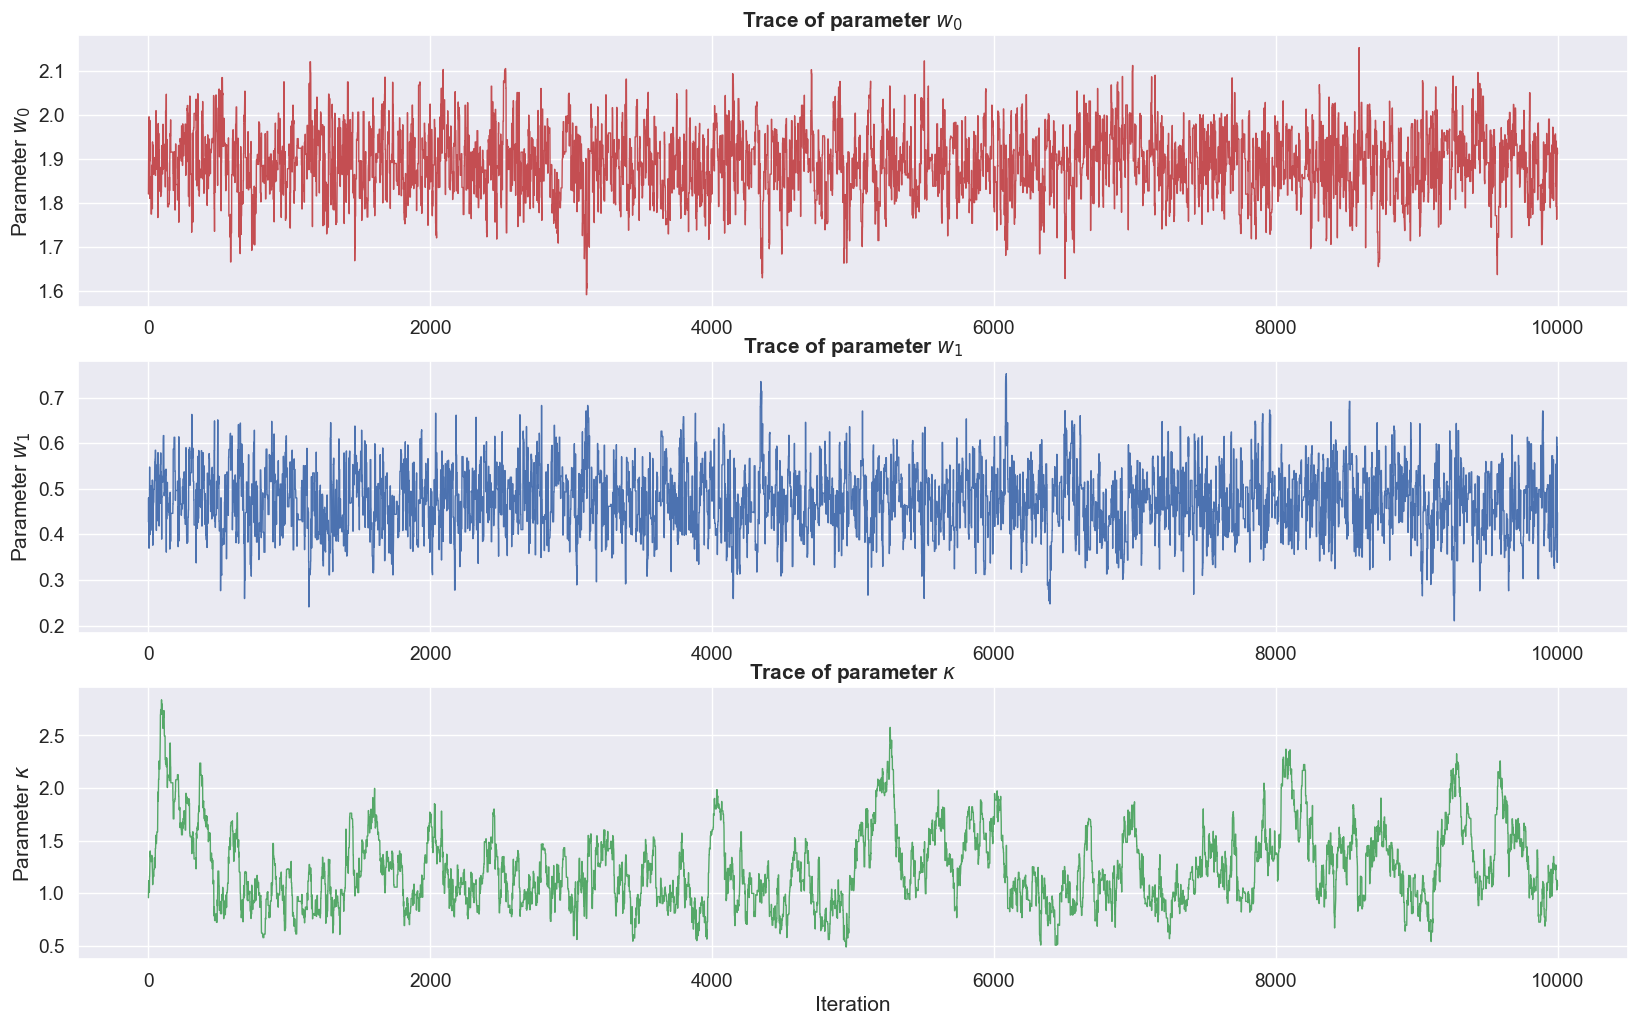

In [72]:
# Set up figure with 2 rows, 3 columns of subplots
fig, axes = plt.subplots(3, 1, figsize=(20, 12))


poisson_warmup = thetas[warm_up:, :] 

# extracting 
w_samples = poisson_warmup[:, :2] # shape (10000, 2)
kappa_samples = poisson_warmup[:, 2] # shape (10000,)

axes[0].plot(poisson_warmup[:, 0], 'r', lw=1)
axes[0].set_title('Trace of parameter $w_0$', fontweight='bold') # Set the title for the first subplot.
axes[0].set_ylabel('Parameter $w_0$') # Label the y-axis (using LaTeX for the theta symbol).
axes[1].plot(poisson_warmup[:, 1], 'b', lw=1)
axes[1].set_title('Trace of parameter $w_1$', fontweight='bold') # Set the title for the first subplot.
axes[1].set_ylabel('Parameter $w_1$') # Label the y-axis (using LaTeX for the theta symbol).
axes[2].plot(poisson_warmup[:, 2], 'g', lw=1)
axes[2].set_title('Trace of parameter $\\kappa$', fontweight='bold') # Set the title for the first subplot.
axes[2].set_xlabel('Iteration')  # Label the x-axis.
axes[2].set_ylabel('Parameter $\\kappa$') # Label the y-axis (using LaTeX for the theta symbol).
plt.show()

plt.show()

**Task 4.3**: Plot a histogram of the posterior samples of $\kappa$ and compare with a histogram of prior samples of $\kappa$. Generate a scatter plot of the posterior samples of the weights and compare to a scatter plot of prior samples of the weights. Based on these plots: do you think the data is more informative about the weights of the linear model $\mathbf{w}$ or the hyperparameter $\kappa$?
_______

The shape of weights posterior $w=[w_0, w_1]$ is 
> w_posterior with shape (S, 2)

The shape of kappa posterior is
> kappa_posterior with shape (S,)
______

TO finish this exercise I first need to generate the key, which is a random number generator. I will use the key to generate the samples. This is a part of the JAX library. The key is used to generate random numbers in a reproducible way.

I need to determine how many saples I want to generate. This will be the same number, as number of the samples, after the warmup phase. 

Next, I generate samples for kappa from the random normal and then I take a absolute value of the samples, since kappa is defined as $\mathcal{N}_+ (0, 1)$. 

Then I generate samples for weights w from the random normal, i.e. $\mathcal{N}(0, \kappa^2 I)$. 


The shape of the $w$ samples is (S, 2), where S is the number of samples. To obtain the prior weights, I need to multiply the distributions of hyperprior $\kappa$ and the prior distribution of $w$, where the equation for this is $$p(w|\kappa^2) = \mathcal{N}_+ (0, \kappa) \times \mathcal{N}(0, \kappa^2 I)$$. 

This broadcasting does the following: it automatically expands $\kappa$ from shape $(S,)$ to shape $(S, 2)$ by repeating its values along the second dimension, so that elementwise multiplication with $w$ (which has shape $(S, 2)$) becomes possible. The result is a tensor of shape $(S, 2)$ where each row $s$ is given by $\kappa_s \times w_s$.

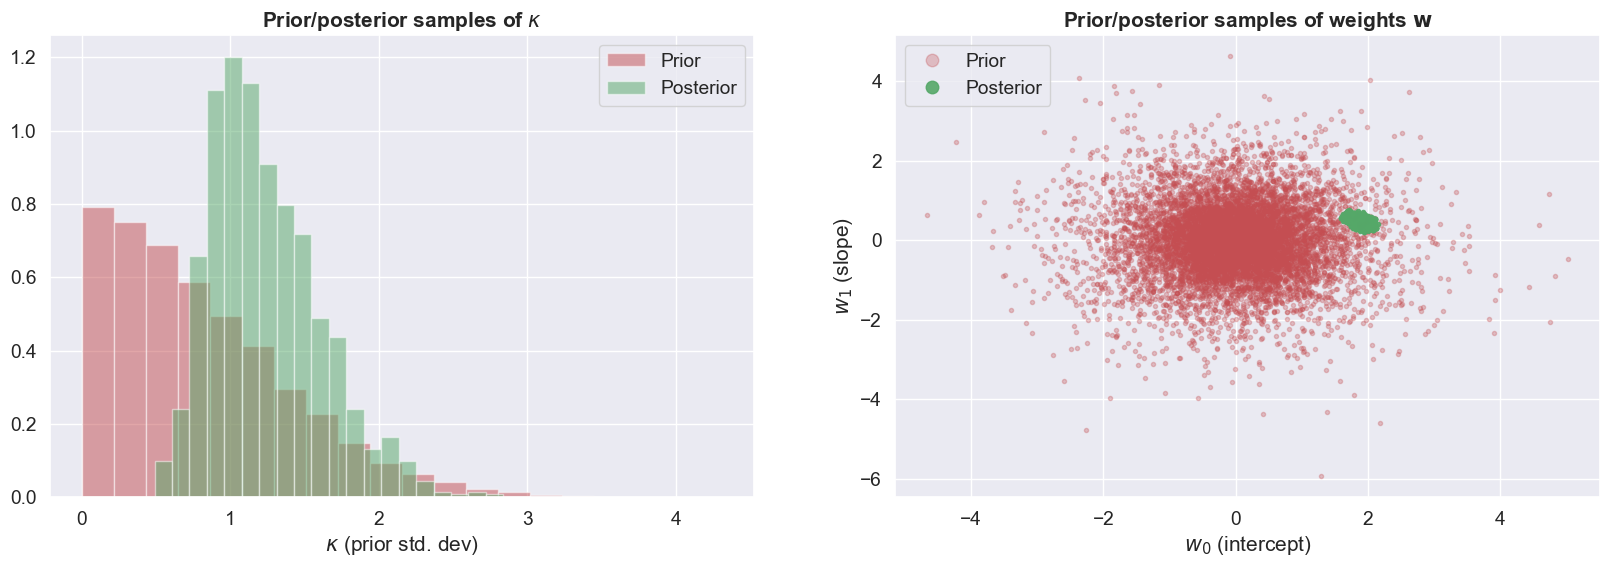

In [76]:
# We have already generated posterior samples for kappa and w (kappa_samples, w_samples).
# Now we want to compare them to prior samples for kappa and w.

# number of posterior samples (S), shape: ()
# kappa_samples has shape (S, ), w_samples has shape (S, 2).
# e.g., if we have 10,000 posterior samples, S=10,000.
S = len(kappa_samples)

# Create a pseudo-random number generator key (seed=1).
# shape: key - PRNGKey object
key = random.PRNGKey(1)
# Split the key into two subkeys key_kappa and key_w for generating different random draws.
key_kappa, key_w = random.split(key, num=2)

# -------------------------------------------------------------------------
# PRIOR SAMPLES FOR kappa:
# kappa ~ N_+(0,1), the half-normal distribution (strictly positive).
# So we draw S samples from N(0,1) and take absolute value -> shape: (S,).
# These represent prior draws of kappa.
# -------------------------------------------------------------------------
kappa_prior_samples = np.abs(random.normal(key_kappa, shape=(S, )))

# -------------------------------------------------------------------------
# PRIOR SAMPLES FOR w:
# w ~ N(0, kappa^2 I). For each draw of kappa_prior_samples[s], we sample w[s].
# That is, w[s] ~ N(0, (kappa_prior_samples[s])^2 I).
# We do this by:
#    w[s] = kappa_prior_samples[s] * Normal(0,1)  (elementwise for w_0, w_1).
# Hence shape of random.normal(...) here is (S, 2).
# Multiplying by kappa_prior_samples[:, None] broadcasts (S, ) to (S, 1).
# Final shape for w_prior_samples is (S, 2).
# -------------------------------------------------------------------------
w_prior_samples = jnp.sqrt(kappa_prior_samples[:, None]) * random.normal(key_w, shape=(S, 2))

# -------------------------------------------------------------------------
# PLOT: compare prior vs. posterior for kappa and w.
# We create a figure with 2 subplots side by side (1 row, 2 columns).
# Left plot: histogram of kappa (prior vs. posterior).
# Right plot: scatter plot of w = (w_0, w_1) (prior vs. posterior).
# -------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Left subplot: Hist of prior/posterior samples for kappa
axes[0].hist(kappa_prior_samples, 20, density=True, color='r', alpha=0.5, label='Prior')
axes[0].hist(kappa_samples, 20, density=True, color='g', alpha=0.5, label='Posterior')
axes[0].set_xlabel('$\\kappa$ (prior std. dev)')
axes[0].set_title('Prior/posterior samples of $\\kappa$', fontweight='bold')
axes[0].legend()

# Right subplot: Scatter of prior/posterior samples for w
# shape of w_prior_samples: (S, 2), w_samples: (S, 2)
axes[1].plot(w_prior_samples[:, 0], w_prior_samples[:, 1], 'r.', alpha=0.3, label='Prior')
axes[1].plot(w_samples[:, 0], w_samples[:, 1], 'g.', alpha=0.9, label='Posterior')
axes[1].legend(loc='upper left', markerscale=3)

axes[1].set_xlabel('$w_0$ (intercept)')
axes[1].set_ylabel('$w_1$ (slope)')
axes[1].set_title('Prior/posterior samples of weights $\\mathbf{w}$', fontweight='bold');

### Making predictions

Now that we have posterior samples for the weights, i.e. $\mathbf{w}^{(i)} \sim p(\mathbf{w} | \mathbf{y})$, we can use them to compute and plot the posterior predictive distribution $p(y^*|\mathbf{y}, \mathbf{x}^*)$ for age between 25 and 70 for our Bayesian Poisson regression model using MC sampling:

$$\begin{align*}
f_*^{(i)} &= (\mathbf{w}^{(i)})^T\mathbf{x}^*\\
\mu_*^{(i)} &= \exp(f_*^{(i)})\\
y_*^{(i)} &\sim \text{Poisson}(\mu_*^{(i)})
\end{align*}$$


for each posterior sample $i = 1, 2, \dots, S$. 

The variable `X_star` is a (P x 2)-shaped array, which contains the input values for the predictions, where $P = 100$ is the number of points in the interval from 25 to 70.

**Task 4.4**: Complete the implementation of the variable `f_star_samples`, `mu_star_samples`, and `y_star_samples`, which should all be (P x num_mcmc_samples)-shapes arrays containing posterior/posterior predictive samples of $f^*$, $\mu^*$ and $y^*$, respectively.

(5001, 2)
(100, 2)
(100, 10001)


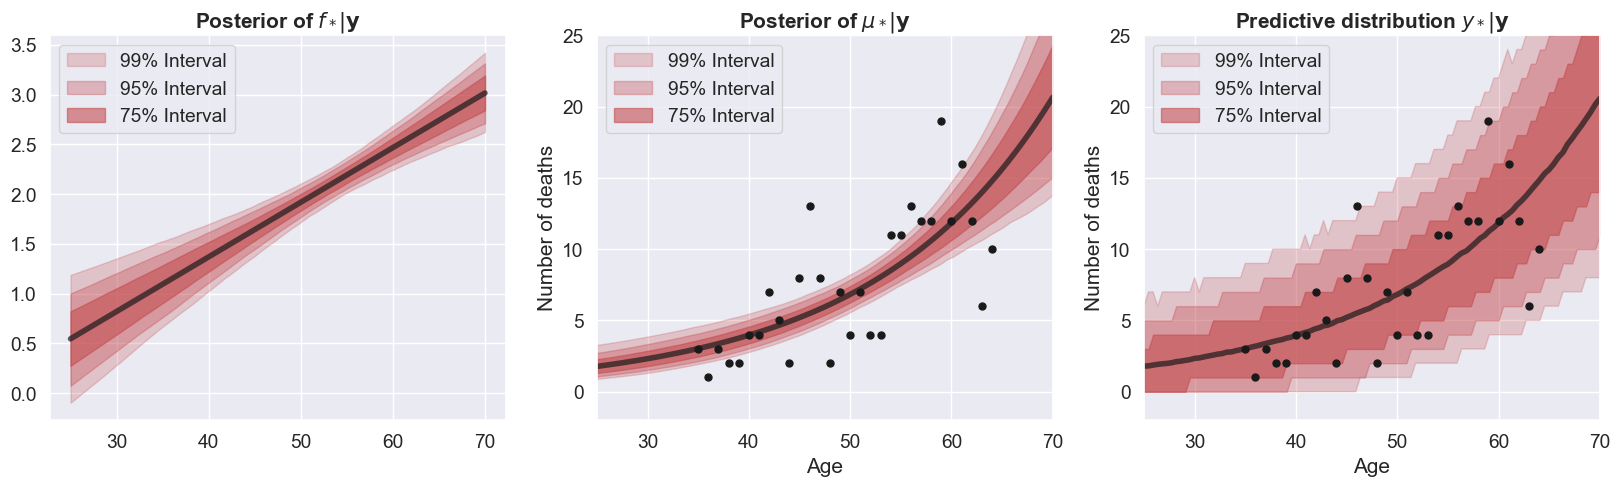

In [ ]:
# thetas_after_warmup has shape (num_mcmc_samples, 3), where each row is (w0, w1, kappa)
# X_star has shape (100, 2), containing 100 rows of input features [1, standardized_age]

print(thetas_after_warmup.shape)  # e.g. (10001, 3)
print(X_star.shape)               # (100, 2)

# w_samples is extracted from thetas_after_warmup[:, :2], so it has shape (num_mcmc_samples, 2)
# The matrix multiplication "X_star @ w_samples.T" yields (100 x num_mcmc_samples):
#   Each of the 100 rows of X_star is multiplied by each of the (w0, w1) rows in w_samples
f_star_samples = X_star @ w_samples.T  # shape = (100, num_mcmc_samples)
print(f_star_samples.shape)

# mu_star_samples applies the exponential link to f_star_samples
# shape remains (100, num_mcmc_samples)
mu_star_samples = jnp.exp(f_star_samples)

# y_star_samples is drawn from a Poisson distribution with mean mu_star_samples
# shape = (100, num_mcmc_samples), each entry is a random integer sample
y_star_samples = np.random.poisson(mu_star_samples)

# Plotting the samples:
#   f_star_samples.T has shape (num_mcmc_samples, 100)
#   mu_star_samples.T has shape (num_mcmc_samples, 100)
#   y_star_samples.T has shape (num_mcmc_samples, 100)
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
plot_predictions(axes[0], age_star, f_star_samples.T, num_samples=0, legend=True, title='Posterior of $f_*|\mathbf{y}$')
plot_predictions(axes[1], age_star, mu_star_samples.T, num_samples=0, legend=True, title='Posterior of $\mu_*|\mathbf{y}$')
plot_predictions(axes[2], age_star, y_star_samples.T, num_samples=0, legend=True, title='Predictive distribution $y_*|\mathbf{y}$')
plot_data(axes[1])
plot_data(axes[2])

# Equations:
# f_* = X_* wᵀ
# μ_* = exp(f_*)
# y_* ~ Poisson(μ_*)

**Task 4.5**: Compute and visualize the posterior distributions for $f_*, \mu_*, y_*$ for $\text{age} = 75$ and report the mean and standard deviation of $p(y_*|\mathbf{y})$ for $\text{age} = 75$

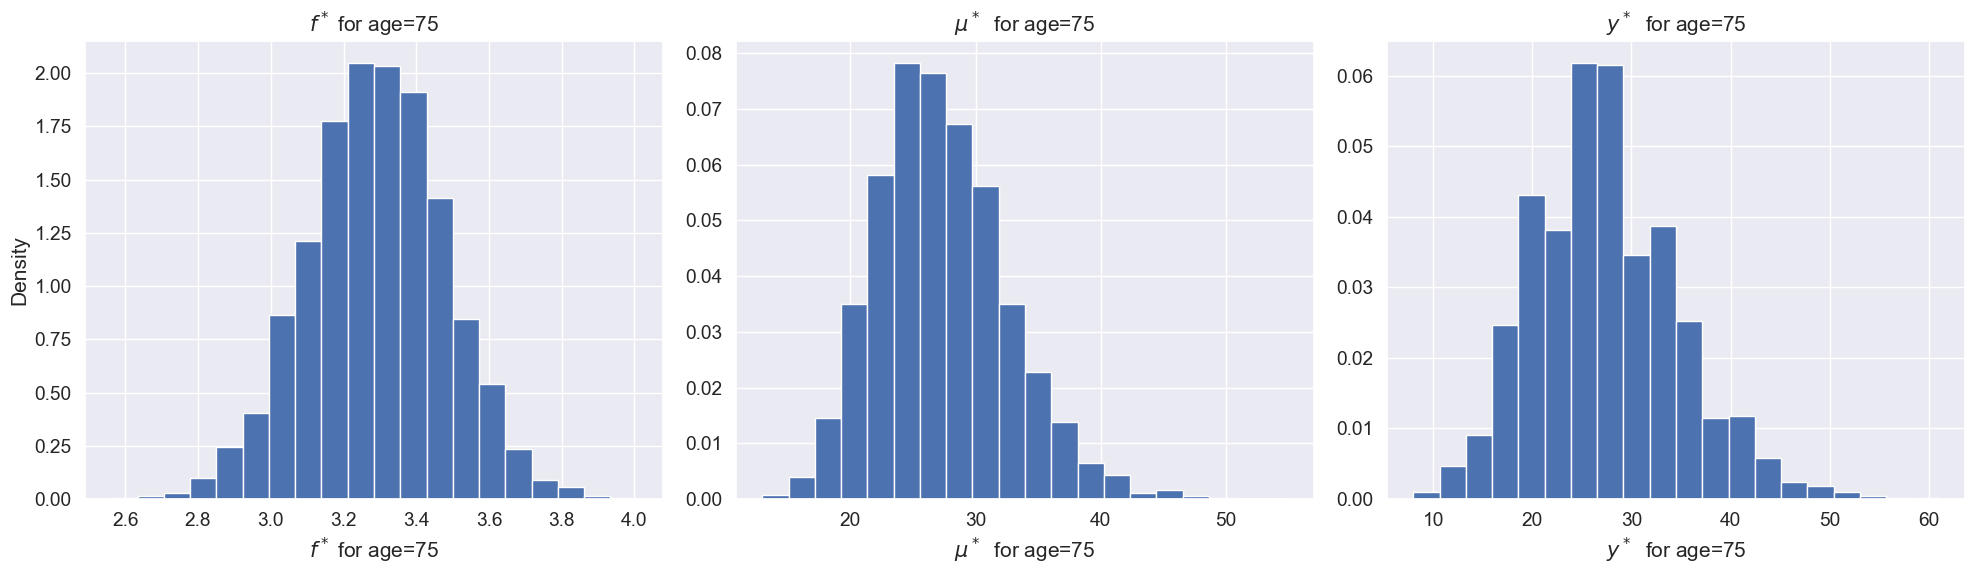

Posterior predictive mean and std. dev for y* at age=75: 27.34 and 7.39


In [85]:
# Assuming the following are available from previous steps:
# - `posterior_samples`: Your MCMC output array (post-warmup), shape (S, 3), where S is the number of samples.
#   Columns correspond to w0, w1, kappa.
# - `w_samples`: Extracted weights from posterior_samples, shape (S, 2).
# - `standardize`: The lambda function used for standardizing age.
# - `m_age`, `s_age`: Mean and std dev used for standardization.

# --- Step 1: Prepare Input for Age 75 ---

# Define a JAX random key for the Poisson sampling step later.
# Using a specific seed ensures reproducibility of the random sampling.
key_poisson = random.PRNGKey(1234)

# Define the new age value for prediction.
age_new = 75
# Standardize the new age using the mean (m_age) and std dev (s_age) from the TRAINING data.
x_new_std = standardize(age_new)
# Create the design matrix row (vector) x* for age=75, including the intercept term (1.0).
# Equation: x* = [1, (age_new - m_age) / s_age]
# Shape: (2,)
x_75 = jnp.array([1.0, x_new_std])

# --- Step 2: Generate Posterior Samples for f* at Age 75 ---

# Calculate samples of the linear predictor f* = w₀ + w₁*x_new_std for age 75.
# We do this for *each* posterior sample of the weights w = [w₀, w₁].
# w_samples has shape (S, 2), x_75 has shape (2,).
# To compute w_s @ x_75 for each row s, we can transpose w_samples and matrix-multiply:
# x_75 (shape 2,) @ w_samples.T (shape 2, S) -> result shape (S,)
# Equation: f*_s = (w_s)ᵀx* = w₀_s * 1 + w₁_s * x_new_std  (for s=1...S)
# f_75 contains S samples from the posterior distribution p(f* | data, x* at age=75)
# Shape: (S,) where S is the number of posterior samples.
f_75 = x_75 @ w_samples.T

# --- Step 3: Generate Posterior Samples for μ* at Age 75 ---

# Calculate samples of the expected Poisson rate μ* = exp(f*) for age 75.
# Apply the inverse link function (exponential) element-wise to each sample of f*.
# Equation: μ*_s = exp(f*_s) (for s=1...S)
# mu_75 contains S samples from the posterior distribution p(μ* | data, x* at age=75)
# Shape: (S,)
mu_75 = jnp.exp(f_75)

# --- Step 4: Generate Posterior Predictive Samples for y* at Age 75 ---

# Generate samples of the predicted death count y* for age 75.
# This simulates the final data generation step, incorporating Poisson noise.
# For each posterior sample of the rate μ*_s, we draw one sample from Poisson(μ*_s).
# Equation: y*_s ~ Poisson(μ*_s) (for s=1...S)
# The function random.poisson(key, lam) draws samples from Poisson distributions
# where 'lam' can be an array of rates (mu_75). It returns one sample per rate.
# y_75 contains S samples from the posterior predictive distribution p(y* | data, x* at age=75)
# Shape: (S,)
y_75 = random.poisson(key_poisson, mu_75)


# --- Step 5: Visualize the Distributions ---

# Create a figure with 3 subplots side-by-side to plot the distributions.
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Iterate through the names and the corresponding sample arrays for plotting.
# zip creates pairs: ('$f^*$ for age=75', f_75), ('$\\mu^*$...', mu_75), ('$y^*$...', y_75)
# enumerate adds an index 'i' (0, 1, 2) for selecting the subplot axis.
for i, (name, values) in enumerate(zip(['$f^*$ for age=75', '$\\mu^*$  for age=75', '$y^*$  for age=75'],
                                     [f_75, mu_75, y_75])):
    # Plot a histogram of the samples on the i-th subplot.
    # `20` specifies the number of bins.
    # `density=True` normalizes the histogram so the area sums to 1, representing a density.
    axes[i].hist(values, 20, density=True)
    # Set the x-axis label for the current subplot.
    axes[i].set_xlabel(name)
    # Set the title for the current subplot.
    axes[i].set_title(name)

# Set the y-axis label for the first plot (index 0). Could be 'Density'.
axes[0].set(ylabel='Density'); # Changed from Count to Density

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# --- Step 6: Report Summary Statistics for Predicted Counts y* ---

# Calculate the sample mean of the posterior predictive samples for y* at age=75.
# This estimates E[y* | data, x* at age=75].
mean_pred_y = np.mean(y_75)
# Calculate the sample standard deviation of the posterior predictive samples for y* at age=75.
# This estimates sqrt(Var(y* | data, x* at age=75]) and quantifies predictive uncertainty.
std_dev_pred_y = np.std(y_75)

# Print the calculated mean and standard deviation, formatted to 2 decimal places.
print('Posterior predictive mean and std. dev for y* at age=75: %3.2f and %3.2f' % (mean_pred_y, std_dev_pred_y))

## Part 5:  Importance sampling



In the final part, we will briefly look at **importance sampling**. Recall, importance sampling is tool for estimating expectations of a function $f$ wrt. a target distribution $p$ using samples from a **proposal distribution** $q$:

$$\begin{align*}
\mathbb{E}_p \left[f(z)\right] = \mathbb{E}_q \left[f(z) \frac{p(z)}{q(z)}\right] \approx \frac{1}{S}\sum_{i=1}^S w^{(i)} f(z^{(i)}) \equiv \hat{f}, \quad z^{(i)} \sim q(z) \quad \text{for} \quad i = 1, \dots, S,
\end{align*}$$

where the **importance weights** $w^{(i)}$ are given by $w^{(i)} = \frac{p(z^{(i)})}{q(z^{(i)})}$. 

Consider again the following Skew-normal distribution:


$$\begin{align*}
p(z) &= 2\phi(z)\Phi(5z),
\end{align*}$$

which is plotted below:

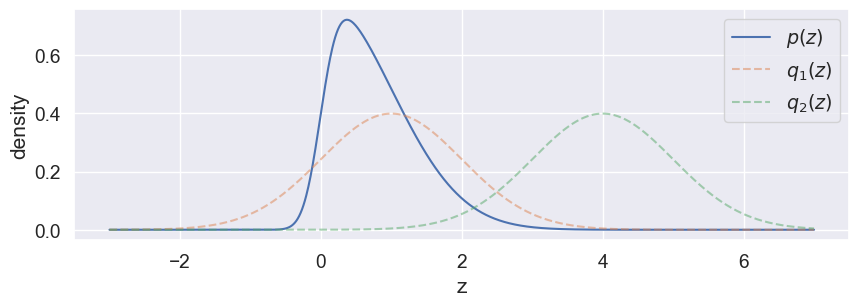

In [ ]:
# We define p(z) = 2 * φ(z) * Φ(5z), where φ(z) is the standard normal PDF and Φ(z) the standard normal CDF.
# Shapes:
#   - zs: (1000,) equally spaced points from -3 to 7
#   - p(zs), q1(zs), q2(zs): (1000,)
# p(z) is defined as:
#   p(z) = 2 · φ(z) · Φ(5z)
# where:
#   - φ(z) = (1/√(2π)) exp(–z²/2) is the standard normal probability density function (PDF)
#   - Φ(z) = ∫₋∞ᶻ φ(t) dt is the standard normal cumulative distribution function (CDF)

# Equation for p(z):
#   p(z) = 2 * norm.pdf(z) * norm.cdf(5*z)

# q1(z) = NormalPDF(z; μ=1, σ=1)
# q2(z) = NormalPDF(z; μ=4, σ=1)

p = lambda z: 2 * norm.pdf(z) * norm.cdf(5*z) # shape (N, )

# Helper function: npdf(z,m,s) = Normal PDF with mean m, std s
#   npdf(z; m, s) = 1/(s√(2π)) · exp( -((z - m)²)/(2s²) )
npdf = lambda z, m, s: (1 / (s * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((z - m) / s) ** 2) # shape (N, )

q1 = lambda z: npdf(z, 1, 1)  # shape (N, ) 
q2 = lambda z: npdf(z, 4, 1)  # shape (N, )

zs = np.linspace(-3, 7, 1000)  # shape(1000,) or (N, )

fig, ax = plt.subplots(1, 1, figsize=(10, 3))

ax.plot(zs, p(zs), label='$p(z)$')
ax.plot(zs, q1(zs), label='$q_1(z)$', linestyle='--', alpha=0.5)
ax.plot(zs, q2(zs), label='$q_2(z)$', linestyle='--', alpha=0.5)
ax.set(xlabel='z', ylabel='density')
ax.legend()

The analytical mean of the distribution is given by 

$$\begin{align*}
\mathbb{E}\left[z\right] = \frac{5}{\sqrt{1+5^2}}\sqrt{\frac{2}\pi} \approx 0.7824
\end{align*}$$

**Task 5.1**: Use importance sampling with a Gaussian proposal, $q(z) = \mathcal{N}(z|1, 1)$, to estimate the mean of the target distribution $p$ for $S = 1000$. How many samples $S$ do you need to get a decent estimate?

*Hints*:
- *Implement a function for computing the importance sampling estimate wrt. the target distribution given the mean and variance of the proposal distribution as well as number of samples to use.*

> Goal is to calculate  the expected value (the mean) of $z$ under the target distribution $p(z)$. Mathematically, this is $E_p[z] = ∫ z * p(z) dz$. \
>**PROBLEM** Sometimes, the target distribution p(z) is difficult or impossible to draw samples from directly. \
> - Even if you can evaluate p(z) for any given z, getting samples distributed according to p(z) might be hard.\
> 
>**IDEA**: What if we could use samples from a different, simpler distribution q(z) (called the proposal distribution) that we can easily sample from? \
>**The Trick (Importance Weights)**: We can rewrite the expectation integral by cleverly multiplying and dividing by $q(z)$ (assuming $q(z) > 0$ wherever $p(z) > 0)$: $E_p[z] = ∫ z * p(z) dz = ∫ z * [p(z) / q(z)] * q(z) dz$ \
>**Rewriting as an Expectation under q(z)**: Notice that the last integral looks like the definition of an expected value with respect to the proposal distribution $q(z)$. It's the expectation of the quantity $z * [p(z) / q(z)]$ if z were drawn from $q(z)$: $E_p[z] = E_q[ z * (p(z) / q(z)) ]$
>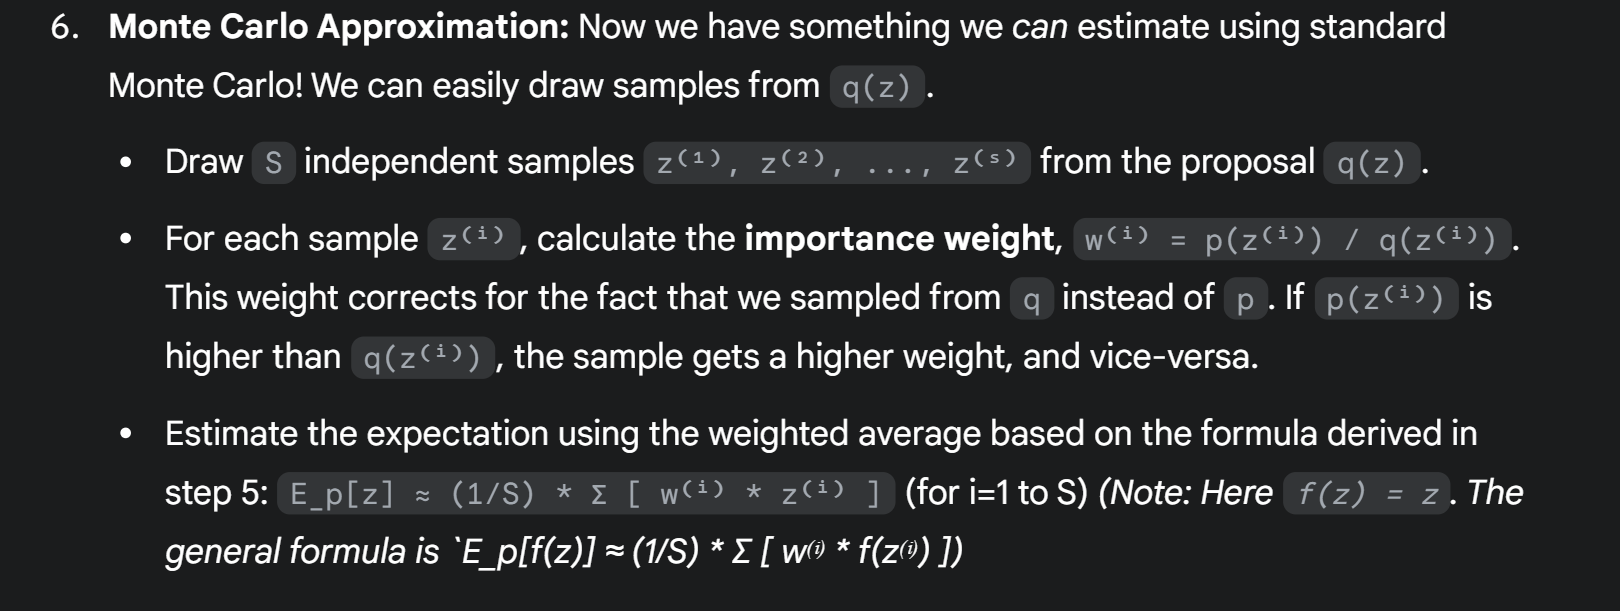

In [ ]:
def importance_sampling(f, p_target, proposal_mean, proposal_variance, sample_size=1000, seed=0):
    # Set the random seed for reproducibility using JAX's random key.
    key = random.PRNGKey(seed)

    # Define the density of the proposal distribution:
    # For a normal distribution with mean (proposal_mean) and variance (proposal_variance),
    # its PDF is: q(z) = (1/√(2π*proposal_variance)) exp( - (z - proposal_mean)² / (2*proposal_variance) )
    q = lambda z: norm.pdf(z, proposal_mean, np.sqrt(proposal_variance))

    # Generate samples from the proposal distribution:
    # z = proposal_mean + sqrt(proposal_variance)*N(0,1)
    # Shape of z: (sample_size,)
    z = proposal_mean + jnp.sqrt(proposal_variance) * random.normal(key, shape=(sample_size,))

    # Compute the importance weights:
    # w = p_target(z) / q(z)
    # This corrects the bias due to sampling from q instead of p_target.
    # Shape of w: (sample_size,)
    w = p_target(z) / q(z)

    # Compute and return the importance sampling estimate:
    # Estimator: E[f(z)] under p_target is approximated by sum(w * f(z)) / sample_size.
    # In this code, f(z) is assumed to be z itself (f = lambda z: z),
    # so the estimate becomes mean(w * z).
    return np.mean(w * z)


for S in [1, 10, 100, 1000, 10000]:
    est = importance_sampling(lambda z: z, p, 1, 1, sample_size=S)
    print(f'IS estimate for S = {S:5d}: {est:3.2f}')

IS estimate for S =     1: 1.18
IS estimate for S =    10: 0.92
IS estimate for S =   100: 0.75
IS estimate for S =  1000: 0.76
IS estimate for S = 10000: 0.78


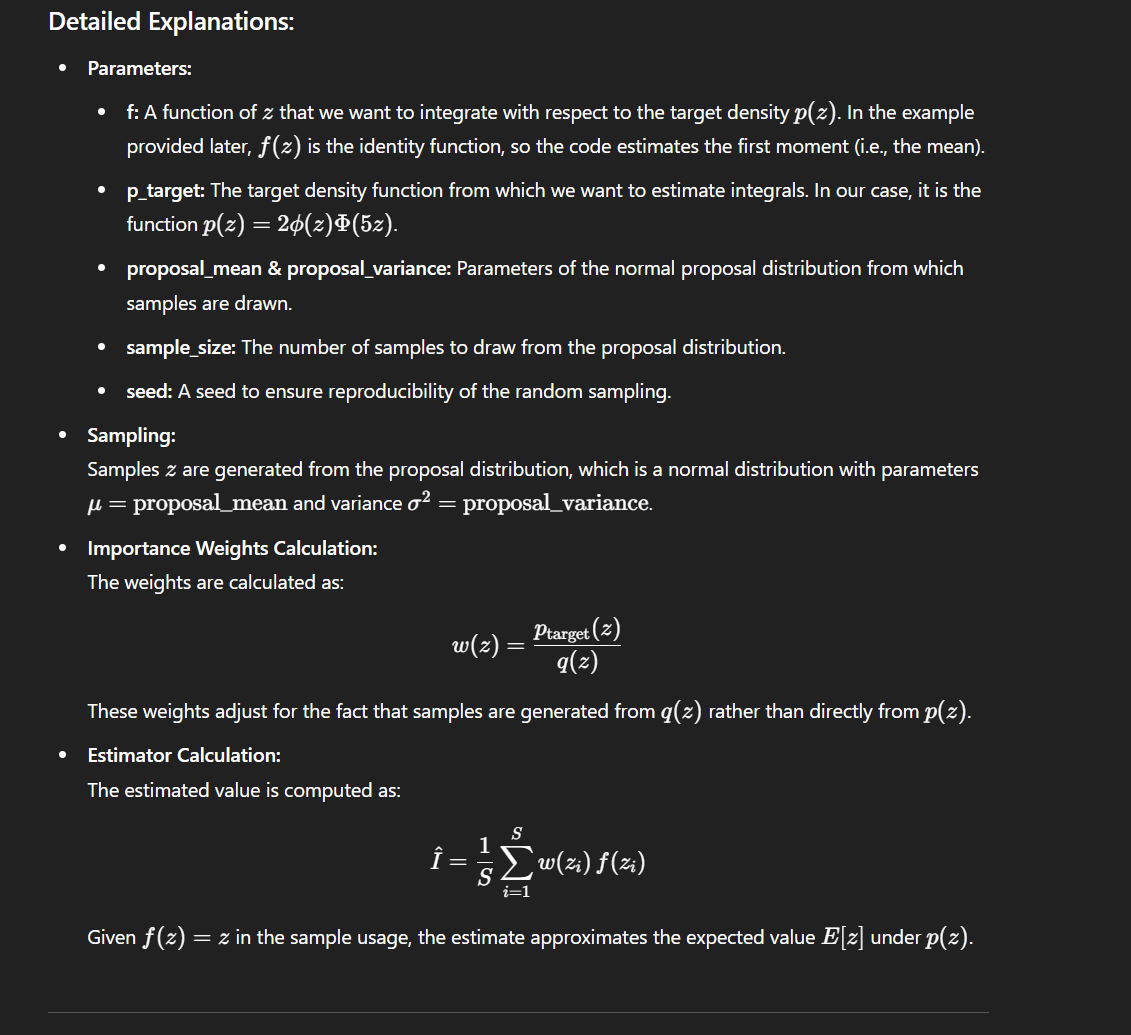

The importance sampling estimator is an **unbiased** estimator, but for importance sampling to work well in practice, the proposal distribution $q$ needs to be relatively "well-aligned" with the target distribution $p$. In the next task, you are going to design a small numerical experiment to investigate this.

**Task 5.2**: Consider two different proposal distributions $q_1(z) = \mathcal{N}(z|1,1)$ and $q_2(z) = \mathcal{N}(z|4,1)$. Compute and plot the importance sampling estimate for the mean of $p(z)$ for both proposal distributions as a function the sample size $S$. Since the importance sampling is an inherently stochastic procedure, you should consider repeating the experiment several times and plot the mean and variance of the estimator across the repetitions as a function of $S$.

*Hints*:
- *There are many valid ways to implement this. The simplest is likely to be via nested for-loops, e.g. an "inner" for loop over the sample size and an "outer" for-loop over the repetitions*
- *Consider $S$ in the range from $S = 1$ to $S = 10^4$.*
- *Remember to use a different seed/key for each repetition.*



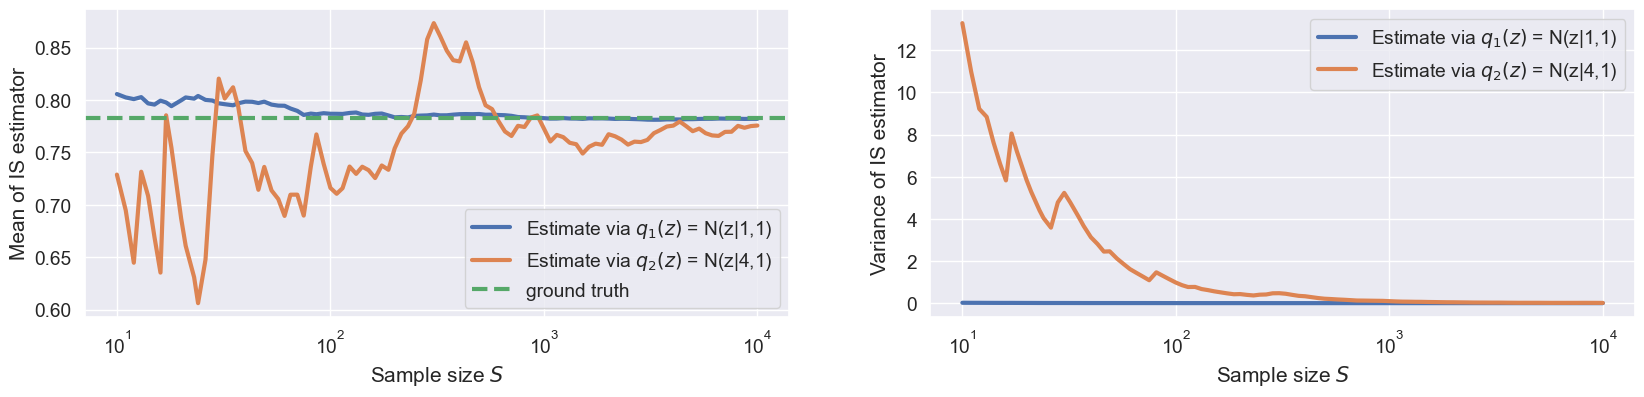

In [ ]:
# ground truth
exact_value = 5/jnp.sqrt(26)*jnp.sqrt(2/jnp.pi)

# settings
num_repetions = 100
num_points = 20

# sample sizes to investigate
samples_sizes = jnp.logspace(1, 4, num_points).astype('int')

# run
estimates1 = np.zeros((num_repetions, num_points))
estimates2 = np.zeros((num_repetions, num_points))
for idx_rep in range(num_repetions):
    for idx_sample_size, sample_size in enumerate(samples_sizes):
        estimates1[idx_rep, idx_sample_size] = importance_sampling(lambda z: z, p, 1, 1, sample_size=sample_size, seed=idx_rep)
        estimates2[idx_rep, idx_sample_size] = importance_sampling(lambda z: z, p, 4, 1, sample_size=sample_size, seed=idx_rep)

# plot
fig, ax = plt.subplots(1, 2, figsize=(20, 4))

# mean
ax[0].plot(samples_sizes, estimates1.mean(0), label='Estimate via $q_1(z)$ = N(z|1,1)', linewidth=3)
ax[0].plot(samples_sizes, estimates2.mean(0), label='Estimate via $q_2(z)$ = N(z|4,1)', linewidth=3)
ax[0].axhline(exact_value, label='ground truth', color='g', linestyle='--', linewidth=3)
ax[0].legend()
ax[0].set(xlabel='Sample size $S$', ylabel='Mean of IS estimator')
ax[0].set_xscale('log')

# variance
ax[1].plot(samples_sizes, np.var(estimates1, axis=0), label='Estimate via $q_1(z)$ = N(z|1,1)', linewidth=3)
ax[1].plot(samples_sizes, np.var(estimates2, axis=0), label='Estimate via $q_2(z)$ = N(z|4,1)', linewidth=3)
ax[1].legend()
ax[1].set(xlabel='Sample size $S$', ylabel='Variance of IS estimator')
ax[1].set_xscale('log')